<a id='top'></a>
# Running the spectroscopic pipeline: NIRSpec Fixed Slit

**Author**: James Muzerolle

Plotting function originally developed by Bryan Hilbert

**Latest Update**: 3 June 2021

## Table of Contents
* [Introduction](#intro)
    * [Overview](#overview)
    * [Simulated data](#sims)
* [Imports](#imports)
* [Convenience functions](#func)
* [Download the data](#data)
* [Input data](#inputs)
* [Level 2 association files](#lvl2asn)
* [Run the calwebb_spec2 pipeline](#runspec2)
* [Run individual steps of the spec2 pipeline](#runspec2steps)
    * [assign_wcs](#awcs)
    * [background](#background)
    * [extract_2d](#extract2d)
    * [sourcetype](#srctype)
    * [wavecorr](#wavecorr)
    * [flat_field](#flat)
    * [pathloss](#pathloss)
    * [photom](#photom)
    * [resample_spec](#resample)
    * [extract_1d](#extract1d)
* [Run the calwebb_spec3 pipeline](#runspec3)

## Introduction <a id='intro'></a>

### Overview <a id='overview'></a>

In this notebook, we will explore the stage 2 and 3 pipelines for spectroscopic data, using the NIRSpec Fixed Slit mode as an example.  Since the previous notebook described the pipelines and all their component steps for all spectroscopic modes, we will focus on the mechanics of processing "real" example data, including how to use associations for background subtraction and multi-exposure combination, what particular steps actually do to the data, and what the primary data products at each stage look like.  We will also briefly examine how to interact and work with data models for each product.

Caveats...

### Simulated data <a id='sims'></a>

We will be using simulated NIRSpec exposures generated by the ESA Instrument Performance Simulator (IPS), using an input scene consisting of a point source with an A-star stellar model spectrum. The observation consists of 9 dithered exposures with the S200A1 slit, including a 3-point primary dither pattern with spectral subdithers. The instrument was configured with the PRISM+CLEAR grating/filter combination and a detector subarray of SUBS200A1 (2048x64 pixels on each detector).

Caveats...

## Imports <a id='imports'></a>

Import packages necessary for this notebook

In [1]:
import numpy as np

import glob

import os
import zipfile
import urllib.request

import json

from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch, LinearStretch, AsinhStretch

Set up matplotlib for plotting

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Use this version for non-interactive plots (easier scrolling of the notebook)
%matplotlib inline

# Use this version (outside of Jupyter Lab) if you want interactive plots
#%matplotlib notebook

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

Import JWST pipeline modules

In [3]:
# The calwebb_spec and spec3 pipelines
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline

# individual steps
from jwst.assign_wcs import AssignWcsStep
from jwst.background import BackgroundStep
from jwst.imprint import ImprintStep
from jwst.msaflagopen import MSAFlagOpenStep
from jwst.extract_2d import Extract2dStep
from jwst.srctype import SourceTypeStep
from jwst.wavecorr import WavecorrStep
from jwst.flatfield import FlatFieldStep
from jwst.pathloss import PathLossStep
from jwst.photom import PhotomStep
from jwst.resample import ResampleSpecStep
from jwst.extract_1d import Extract1dStep

# data models
from jwst import datamodels

2021-06-03 15:46:22,348 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/photutils/detection/findstars.py:33: AstropyDeprecationWarning: _StarFinderKernel was moved to the photutils.detection._utils module. Please update your import statement.
  warnings.warn(f'{name} was moved to the {deprecated[name]} module. '



## Define convenience functions and parameters <a id='func'></a>

In [4]:
# All files created in this notebook will be saved to the current working directory
output_dir = './nirspec_files/'

In [5]:
def show_image(data_2d, vmin, vmax, title=None, aspect=1, scale='log', units='MJy/sr'):
    """Function to generate a 2D, log-scaled image of the data
    
    Parameters
    ----------
    data_2d : numpy.ndarray
        2D image to be displayed
        
    vmin : float
        Minimum signal value to use for scaling
        
    vmax : float
        Maximum signal value to use for scaling
        
    title : str
        String to use for the plot title
        
    scale : str
        Specify scaling of the image. Can be 'log' or 'linear'
        
    units : str
        Units of the data. Used for the annotation in the
        color bar
    """
    if scale == 'log':
        norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=LogStretch())
    elif scale == 'linear':
        norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=LinearStretch())
    elif scale == 'Asinh':
        norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=AsinhStretch())
    fig = plt.figure(figsize=(15, 9))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(data_2d, origin='lower', norm=norm, aspect=aspect, cmap='gist_earth')

    fig.colorbar(im, label=units)
    plt.xlabel('Pixel column')
    plt.ylabel('Pixel row')
    if title:
        plt.title(title)

## Download the data <a id='data'></a>

First, let's grab the data from Box.

In [17]:
# set the Box link and file name
ziplink = 'https://stsci.box.com/shared/static/qdj79y7rv99wuui2hot0l3kg5ohq0ah9.zip'
zipfilename = 'nirspec_data.zip'
if not os.path.isfile(os.path.join(output_dir, zipfilename)):
    print('Downloading {}...'.format(zipfilename))
    demo_file = download_file(ziplink, cache=True)
    # Make a symbolic link using a local name for convenience
    os.symlink(demo_file, os.path.join(output_dir, zipfilename))
else:
    print('{} already exists, skipping download...'.format(zipfilename))

In [18]:
# unzip
zf = zipfile.ZipFile(output_dir+'nirspec_data.zip','r')
zf.extractall(output_dir)

## Input data <a id='inputs'></a>

Because the simulator generates count rate maps, equivalent to level 2a data products, we have to skip stage 1 of the pipeline and instead start the processing with the calwebb_spec2 pipeline.

First, let's take a look at a few of the level 2a images to get familiarized with the inputs.

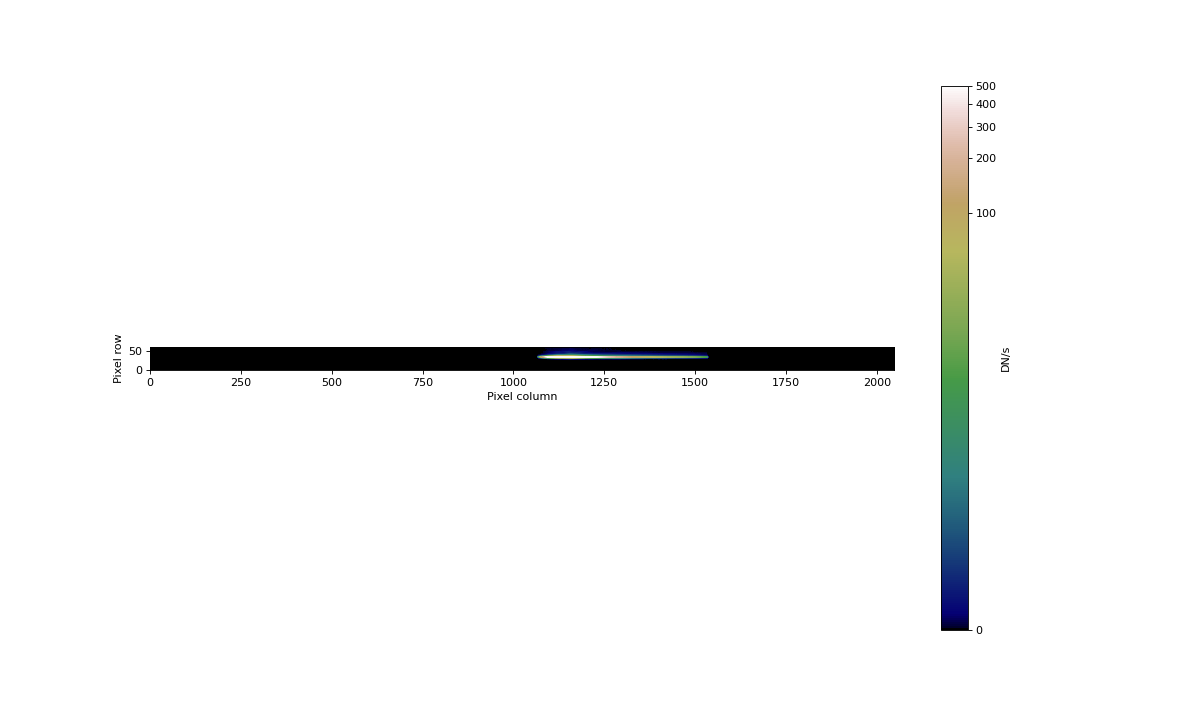

In [19]:
# get the data model of dither position 1:
ratefile = output_dir+'nirspec_fssim_d1_rate.fits'
dither = datamodels.open(ratefile)

# get the pixel data (the SCI extension of the fits file)
ratesci = dither.data

# display the image
show_image(ratesci,0,5.e2,units='DN/s')

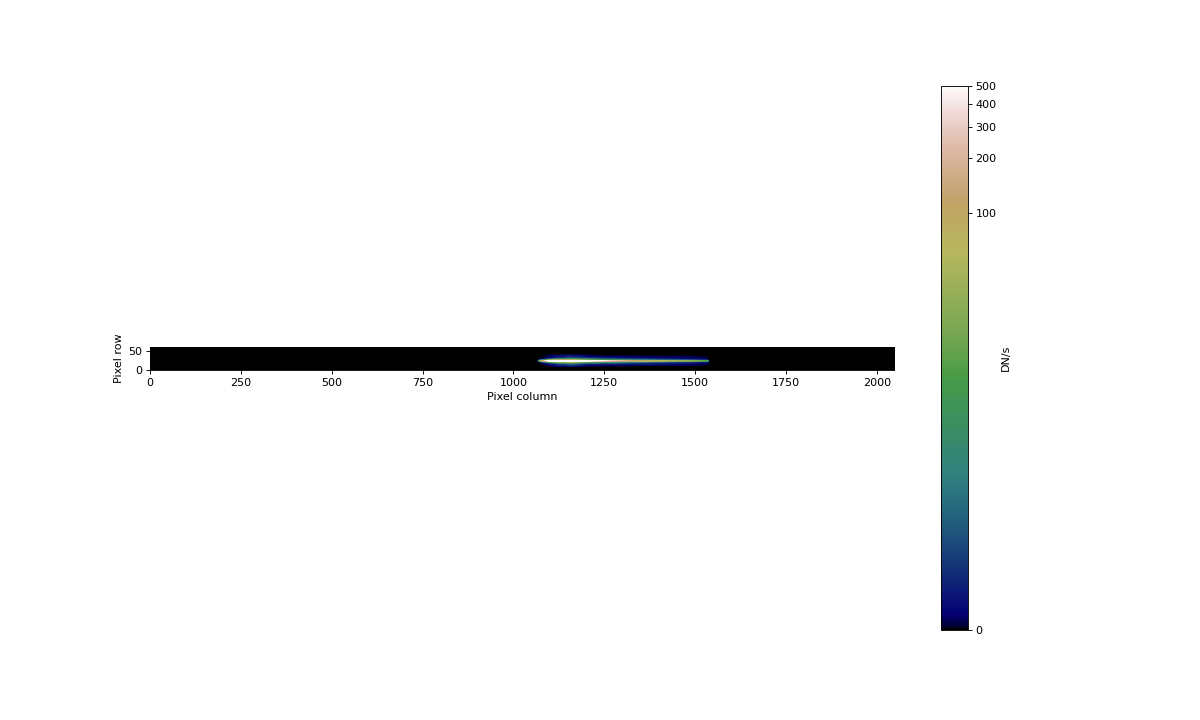

In [20]:
# get the data model of dither position 4:
ratefile = output_dir+'nirspec_fssim_d4_rate.fits'
dither = datamodels.open(ratefile)

# get the pixel data (the SCI extension of the fits file)
ratesci = dither.data

# display the image
show_image(ratesci,0,5.e2,units='DN/s')

## Level 2 association files <a id='lvl2asn'></a>

One purpose of the primary dither pattern in this case is to enable background subtraction.  The spec2 pipeline is set up to handle this by using association files that list the exposures to be used as backgrounds for each input exposure.  The background elements can also be specified manually as inputs into the "background" step, but we'll be using association files in this example.

In [21]:
# get the association files
asnlist = [f for f in glob.glob(output_dir+"spec2*json")]
asnlist.sort()
print(asnlist)

['./nirspec_files/spec2_001_asn.json', './nirspec_files/spec2_002_asn.json', './nirspec_files/spec2_003_asn.json', './nirspec_files/spec2_004_asn.json', './nirspec_files/spec2_005_asn.json', './nirspec_files/spec2_006_asn.json', './nirspec_files/spec2_007_asn.json', './nirspec_files/spec2_008_asn.json', './nirspec_files/spec2_009_asn.json']


In [22]:
# show the contents of one of the association files
asn_file = asnlist[0]
with open(asn_file) as f_obj:
  asn_data = json.load(f_obj)
asn_data

{'asn_type': 'spec2',
 'asn_rule': 'candidate_Asn_Lv2NRSFSS',
 'version_id': '20210311t152305',
 'code_version': '1.1.0',
 'degraded_status': 'No known degraded exposures in association.',
 'program': '00675',
 'constraints': 'DMSAttrConstraint({\'name\': \'program\', \'sources\': [\'program\'], \'value\': \'675\'})\nDMSAttrConstraint({\'name\': \'is_tso\', \'sources\': [\'tsovisit\'], \'value\': None})\nDMSAttrConstraint({\'name\': \'instrument\', \'sources\': [\'instrume\'], \'value\': \'nirspec\'})\nDMSAttrConstraint({\'name\': \'detector\', \'sources\': [\'detector\'], \'value\': \'nrs1\'})\nDMSAttrConstraint({\'name\': \'opt_elem\', \'sources\': [\'filter\'], \'value\': \'clear\'})\nDMSAttrConstraint({\'name\': \'opt_elem2\', \'sources\': [\'grating\'], \'value\': \'prism\'})\nDMSAttrConstraint({\'name\': \'opt_elem3\', \'sources\': [\'fxd_slit\'], \'value\': \'s200a1\'})\nDMSAttrConstraint({\'name\': \'subarray\', \'sources\': [\'subarray\'], \'value\': \'subs200a1\'})\nDMSAttrCo

## Run the calwebb_spec2 pipeline <a id='runspec2'></a>

In [23]:
# run the calwebb_spec2 pipeline using association files as inputs

# loop over the association files (one per exposure)
for asn in asnlist:
    spec2 = Spec2Pipeline()
    spec2.save_results = True
    spec2.output_dir = output_dir
    # skip the flat field correction, since the simulations do not include a full treatment of the throughput
    spec2.flat_field.skip = True
    result = spec2(asn)

2021-06-03 18:34:43,796 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-06-03 18:34:43,798 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-06-03 18:34:43,800 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-06-03 18:34:43,802 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-06-03 18:34:43,804 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2021-06-03 18:34:43,805 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2021-06-03 18:34:43,810 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.
2021-06-03 18:34:43,811 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.
2021-06-03 18:34:43,812 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.
2021-06-03 18:34:43,814 - stpipe.Spec2Pipeline.master_

2021-06-03 18:34:44,038 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'nirspec_fssim_d1_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'disperser', 'distortion', 'drizpars', 'extract1d', 'filteroffset', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'resol', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-06-03 18:34:51,047 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_apcorr_0003.fits'.
2021-06-03 18:34:51,096 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_area_0020.fits'.
2021-06-03 18:34:51,150 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-06-03 18:34:51,151 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/grp/crds/cache/references/jwst/jws

2021-06-03 18:35:01,528 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': './nirspec_files', 'sigma': 3.0, 'maxiters': None}
2021-06-03 18:35:02,595 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2021-06-03 18:35:02,674 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(64, 2048) from nirspec_fssim_d1_rate.fits>, []).
2021-06-03 18:35:02,676 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_outp

2021-06-03 18:35:07,634 - stpipe.Spec2Pipeline.flat_field - INFO - Step skipped.
2021-06-03 18:35:07,635 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done
2021-06-03 18:35:07,708 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<MultiSlitModel from nirspec_fssim_d1_rate.fits>,).
2021-06-03 18:35:07,710 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': './nirspec_files', 'inverse': False, 'source_type': None}
2021-06-03 18:35:07,765 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /grp/crds/cache/references/jwst/jwst_nirspec_pathloss_0001.fits
2021-06-03 18:35:08,283 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is NRS_FIXEDSLIT
2021-06-03 18:35:08

2021-06-03 18:35:14,313 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-06-03 18:35:14,315 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-06-03 18:35:14,316 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2021-06-03 18:35:14,317 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2021-06-03 18:35:14,321 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.
2021-06-03 18:35:14,323 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.
2021-06-03 18:35:14,324 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.
2021-06-03 18:35:14,326 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.
2021-06-03 18:35:14,328 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.
2021-06-03 18:35:1

2021-06-03 18:35:14,563 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'nirspec_fssim_d2_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'disperser', 'distortion', 'drizpars', 'extract1d', 'filteroffset', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'resol', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-06-03 18:35:14,758 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_apcorr_0003.fits'.
2021-06-03 18:35:14,783 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_area_0020.fits'.
2021-06-03 18:35:14,810 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-06-03 18:35:14,811 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/grp/crds/cache/references/jwst/jws

2021-06-03 18:35:22,200 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': './nirspec_files', 'sigma': 3.0, 'maxiters': None}
2021-06-03 18:35:23,239 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2021-06-03 18:35:23,326 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(64, 2048) from nirspec_fssim_d2_rate.fits>, []).
2021-06-03 18:35:23,328 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_outp

2021-06-03 18:35:24,402 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit S200A1
2021-06-03 18:35:24,403 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2021-06-03 18:35:25,498 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture S200A1
2021-06-03 18:35:25,504 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done
2021-06-03 18:35:25,593 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<MultiSlitModel from nirspec_fssim_d2_rate.fits>,).
2021-06-03 18:35:25,595 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './nirspec_files', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': Fals

2021-06-03 18:35:27,656 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=434, ystart=25.05847938661859, ystop=31.05847938661859
2021-06-03 18:35:27,720 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2021-06-03 18:35:28,322 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in ./nirspec_files/nirspec_fssim_d2_x1d.fits
2021-06-03 18:35:28,323 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2021-06-03 18:35:28,323 - stpipe.Spec2Pipeline - INFO - Finished processing product nirspec_fssim_d2
2021-06-03 18:35:28,324 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-06-03 18:35:28,611 - stpipe.Spec2Pipeline - INFO - Saved model in ./nirspec_files/nirspec_fssim_d2_cal.fits
2021-06-03 18:35:28,612 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-06-03 18:35:28,627 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-06-03 18:35:28,628 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance c

2021-06-03 18:35:28,899 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'nirspec_fssim_d3_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'disperser', 'distortion', 'drizpars', 'extract1d', 'filteroffset', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'resol', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-06-03 18:35:29,109 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_apcorr_0003.fits'.
2021-06-03 18:35:29,143 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_area_0020.fits'.
2021-06-03 18:35:29,168 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-06-03 18:35:29,168 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/grp/crds/cache/references/jwst/jws

2021-06-03 18:35:36,392 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': './nirspec_files', 'sigma': 3.0, 'maxiters': None}
2021-06-03 18:35:37,358 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2021-06-03 18:35:37,443 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(64, 2048) from nirspec_fssim_d3_rate.fits>, []).
2021-06-03 18:35:37,445 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_outp

2021-06-03 18:35:38,483 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit S200A1
2021-06-03 18:35:38,485 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2021-06-03 18:35:39,592 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture S200A1
2021-06-03 18:35:39,597 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done
2021-06-03 18:35:39,683 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<MultiSlitModel from nirspec_fssim_d3_rate.fits>,).
2021-06-03 18:35:39,685 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './nirspec_files', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': Fals

2021-06-03 18:35:41,719 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=434, ystart=24.808140196035957, ystop=30.808140196035957
2021-06-03 18:35:41,775 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2021-06-03 18:35:42,339 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in ./nirspec_files/nirspec_fssim_d3_x1d.fits
2021-06-03 18:35:42,339 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2021-06-03 18:35:42,340 - stpipe.Spec2Pipeline - INFO - Finished processing product nirspec_fssim_d3
2021-06-03 18:35:42,340 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-06-03 18:35:42,626 - stpipe.Spec2Pipeline - INFO - Saved model in ./nirspec_files/nirspec_fssim_d3_cal.fits
2021-06-03 18:35:42,627 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-06-03 18:35:42,641 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-06-03 18:35:42,643 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance

2021-06-03 18:35:42,894 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'nirspec_fssim_d4_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'disperser', 'distortion', 'drizpars', 'extract1d', 'filteroffset', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'resol', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-06-03 18:35:43,092 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_apcorr_0003.fits'.
2021-06-03 18:35:43,117 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_area_0020.fits'.
2021-06-03 18:35:43,144 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-06-03 18:35:43,145 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/grp/crds/cache/references/jwst/jws

2021-06-03 18:35:50,556 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': './nirspec_files', 'sigma': 3.0, 'maxiters': None}
2021-06-03 18:35:51,558 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2021-06-03 18:35:51,643 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(64, 2048) from nirspec_fssim_d4_rate.fits>, []).
2021-06-03 18:35:51,645 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_outp

2021-06-03 18:35:52,822 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit S200A1
2021-06-03 18:35:52,823 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2021-06-03 18:35:53,913 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture S200A1
2021-06-03 18:35:53,920 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done
2021-06-03 18:35:54,009 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<MultiSlitModel from nirspec_fssim_d4_rate.fits>,).
2021-06-03 18:35:54,010 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './nirspec_files', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': Fals

2021-06-03 18:35:56,212 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=434, ystart=14.973302809196944, ystop=20.973302809196944
2021-06-03 18:35:56,281 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2021-06-03 18:35:57,124 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in ./nirspec_files/nirspec_fssim_d4_x1d.fits
2021-06-03 18:35:57,124 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2021-06-03 18:35:57,125 - stpipe.Spec2Pipeline - INFO - Finished processing product nirspec_fssim_d4
2021-06-03 18:35:57,126 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-06-03 18:35:57,532 - stpipe.Spec2Pipeline - INFO - Saved model in ./nirspec_files/nirspec_fssim_d4_cal.fits
2021-06-03 18:35:57,533 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-06-03 18:35:57,550 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-06-03 18:35:57,552 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance

2021-06-03 18:35:57,836 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'nirspec_fssim_d5_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'disperser', 'distortion', 'drizpars', 'extract1d', 'filteroffset', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'resol', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-06-03 18:35:58,025 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_apcorr_0003.fits'.
2021-06-03 18:35:58,051 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_area_0020.fits'.
2021-06-03 18:35:58,075 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-06-03 18:35:58,076 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/grp/crds/cache/references/jwst/jws

2021-06-03 18:36:05,521 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': './nirspec_files', 'sigma': 3.0, 'maxiters': None}
2021-06-03 18:36:06,604 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2021-06-03 18:36:06,690 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(64, 2048) from nirspec_fssim_d5_rate.fits>, []).
2021-06-03 18:36:06,692 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_outp

2021-06-03 18:36:07,764 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit S200A1
2021-06-03 18:36:07,766 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2021-06-03 18:36:08,860 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture S200A1
2021-06-03 18:36:08,866 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done
2021-06-03 18:36:08,954 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<MultiSlitModel from nirspec_fssim_d5_rate.fits>,).
2021-06-03 18:36:08,956 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './nirspec_files', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': Fals

2021-06-03 18:36:10,997 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=434, ystart=14.722838713033664, ystop=20.722838713033664
2021-06-03 18:36:11,053 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2021-06-03 18:36:11,611 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in ./nirspec_files/nirspec_fssim_d5_x1d.fits
2021-06-03 18:36:11,611 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2021-06-03 18:36:11,612 - stpipe.Spec2Pipeline - INFO - Finished processing product nirspec_fssim_d5
2021-06-03 18:36:11,613 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-06-03 18:36:11,909 - stpipe.Spec2Pipeline - INFO - Saved model in ./nirspec_files/nirspec_fssim_d5_cal.fits
2021-06-03 18:36:11,910 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-06-03 18:36:11,923 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-06-03 18:36:11,925 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance

2021-06-03 18:36:12,184 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'nirspec_fssim_d6_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'disperser', 'distortion', 'drizpars', 'extract1d', 'filteroffset', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'resol', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-06-03 18:36:12,388 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_apcorr_0003.fits'.
2021-06-03 18:36:12,412 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_area_0020.fits'.
2021-06-03 18:36:12,436 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-06-03 18:36:12,436 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/grp/crds/cache/references/jwst/jws

2021-06-03 18:36:19,636 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': './nirspec_files', 'sigma': 3.0, 'maxiters': None}
2021-06-03 18:36:20,711 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2021-06-03 18:36:20,805 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(64, 2048) from nirspec_fssim_d6_rate.fits>, []).
2021-06-03 18:36:20,806 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_outp

2021-06-03 18:36:21,878 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit S200A1
2021-06-03 18:36:21,879 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2021-06-03 18:36:22,951 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture S200A1
2021-06-03 18:36:22,959 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done
2021-06-03 18:36:23,049 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<MultiSlitModel from nirspec_fssim_d6_rate.fits>,).
2021-06-03 18:36:23,051 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './nirspec_files', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': Fals

2021-06-03 18:36:25,895 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=434, ystart=14.472508319905266, ystop=20.472508319905266
2021-06-03 18:36:25,951 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2021-06-03 18:36:26,515 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in ./nirspec_files/nirspec_fssim_d6_x1d.fits
2021-06-03 18:36:26,516 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2021-06-03 18:36:26,516 - stpipe.Spec2Pipeline - INFO - Finished processing product nirspec_fssim_d6
2021-06-03 18:36:26,517 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-06-03 18:36:26,798 - stpipe.Spec2Pipeline - INFO - Saved model in ./nirspec_files/nirspec_fssim_d6_cal.fits
2021-06-03 18:36:26,799 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-06-03 18:36:26,813 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-06-03 18:36:26,814 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance

2021-06-03 18:36:27,073 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'nirspec_fssim_d7_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'disperser', 'distortion', 'drizpars', 'extract1d', 'filteroffset', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'resol', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-06-03 18:36:27,272 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_apcorr_0003.fits'.
2021-06-03 18:36:27,301 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_area_0020.fits'.
2021-06-03 18:36:27,330 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-06-03 18:36:27,331 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/grp/crds/cache/references/jwst/jws

2021-06-03 18:36:34,551 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': './nirspec_files', 'sigma': 3.0, 'maxiters': None}
2021-06-03 18:36:35,538 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2021-06-03 18:36:35,625 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(64, 2048) from nirspec_fssim_d7_rate.fits>, []).
2021-06-03 18:36:35,627 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_outp

2021-06-03 18:36:36,693 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit S200A1
2021-06-03 18:36:36,695 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2021-06-03 18:36:37,768 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture S200A1
2021-06-03 18:36:37,774 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done
2021-06-03 18:36:37,866 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<MultiSlitModel from nirspec_fssim_d7_rate.fits>,).
2021-06-03 18:36:37,868 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './nirspec_files', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': Fals

2021-06-03 18:36:39,925 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=434, ystart=6.637002420602844, ystop=12.637002420602844
2021-06-03 18:36:39,980 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2021-06-03 18:36:40,552 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in ./nirspec_files/nirspec_fssim_d7_x1d.fits
2021-06-03 18:36:40,553 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2021-06-03 18:36:40,553 - stpipe.Spec2Pipeline - INFO - Finished processing product nirspec_fssim_d7
2021-06-03 18:36:40,554 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-06-03 18:36:40,853 - stpipe.Spec2Pipeline - INFO - Saved model in ./nirspec_files/nirspec_fssim_d7_cal.fits
2021-06-03 18:36:40,854 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-06-03 18:36:40,868 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-06-03 18:36:40,869 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance 

2021-06-03 18:36:41,127 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'nirspec_fssim_d8_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'disperser', 'distortion', 'drizpars', 'extract1d', 'filteroffset', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'resol', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-06-03 18:36:41,334 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_apcorr_0003.fits'.
2021-06-03 18:36:41,366 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_area_0020.fits'.
2021-06-03 18:36:41,389 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-06-03 18:36:41,390 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/grp/crds/cache/references/jwst/jws

2021-06-03 18:36:48,623 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': './nirspec_files', 'sigma': 3.0, 'maxiters': None}
2021-06-03 18:36:49,620 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2021-06-03 18:36:49,716 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(64, 2048) from nirspec_fssim_d8_rate.fits>, []).
2021-06-03 18:36:49,718 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_outp

2021-06-03 18:36:50,843 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit S200A1
2021-06-03 18:36:50,845 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2021-06-03 18:36:51,906 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture S200A1
2021-06-03 18:36:51,912 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done
2021-06-03 18:36:52,004 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<MultiSlitModel from nirspec_fssim_d8_rate.fits>,).
2021-06-03 18:36:52,006 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './nirspec_files', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': Fals

2021-06-03 18:36:54,035 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=434, ystart=6.386672158655198, ystop=12.386672158655198
2021-06-03 18:36:54,090 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2021-06-03 18:36:54,650 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in ./nirspec_files/nirspec_fssim_d8_x1d.fits
2021-06-03 18:36:54,651 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2021-06-03 18:36:54,651 - stpipe.Spec2Pipeline - INFO - Finished processing product nirspec_fssim_d8
2021-06-03 18:36:54,652 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-06-03 18:36:54,932 - stpipe.Spec2Pipeline - INFO - Saved model in ./nirspec_files/nirspec_fssim_d8_cal.fits
2021-06-03 18:36:54,933 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-06-03 18:36:54,947 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-06-03 18:36:54,949 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance 

2021-06-03 18:36:55,201 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'nirspec_fssim_d9_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'disperser', 'distortion', 'drizpars', 'extract1d', 'filteroffset', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'resol', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-06-03 18:36:55,401 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_apcorr_0003.fits'.
2021-06-03 18:36:55,439 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_area_0020.fits'.
2021-06-03 18:36:55,492 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-06-03 18:36:55,493 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/grp/crds/cache/references/jwst/jws

2021-06-03 18:37:03,098 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': './nirspec_files', 'sigma': 3.0, 'maxiters': None}
2021-06-03 18:37:04,152 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2021-06-03 18:37:04,245 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(64, 2048) from nirspec_fssim_d9_rate.fits>, []).
2021-06-03 18:37:04,246 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_outp

2021-06-03 18:37:05,295 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit S200A1
2021-06-03 18:37:05,296 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2021-06-03 18:37:06,394 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture S200A1
2021-06-03 18:37:06,400 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done
2021-06-03 18:37:06,486 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<MultiSlitModel from nirspec_fssim_d9_rate.fits>,).
2021-06-03 18:37:06,488 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './nirspec_files', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': Fals

2021-06-03 18:37:08,500 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=434, ystart=6.1363329696830995, ystop=12.1363329696831
2021-06-03 18:37:08,558 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2021-06-03 18:37:09,181 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in ./nirspec_files/nirspec_fssim_d9_x1d.fits
2021-06-03 18:37:09,182 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2021-06-03 18:37:09,183 - stpipe.Spec2Pipeline - INFO - Finished processing product nirspec_fssim_d9
2021-06-03 18:37:09,183 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-06-03 18:37:09,517 - stpipe.Spec2Pipeline - INFO - Saved model in ./nirspec_files/nirspec_fssim_d9_cal.fits
2021-06-03 18:37:09,517 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2021-06-03 18:37:09,526 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



./nirspec_files/nirspec_fssim_d1_cal.fits
S200A1


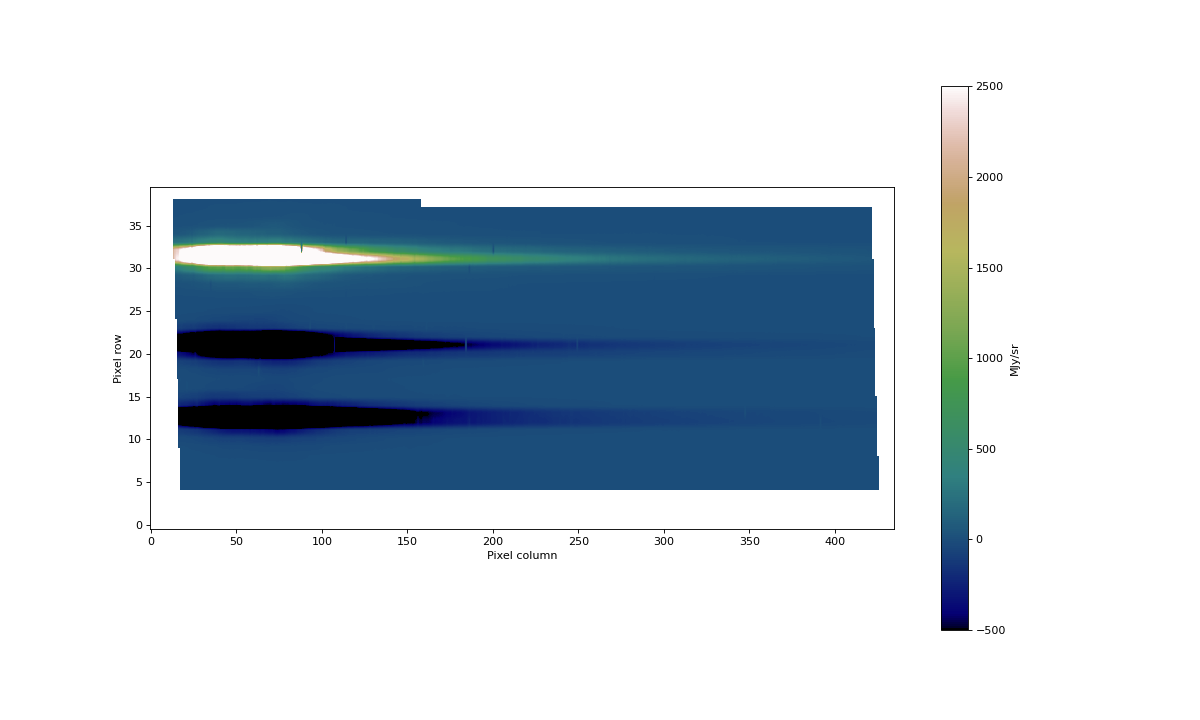

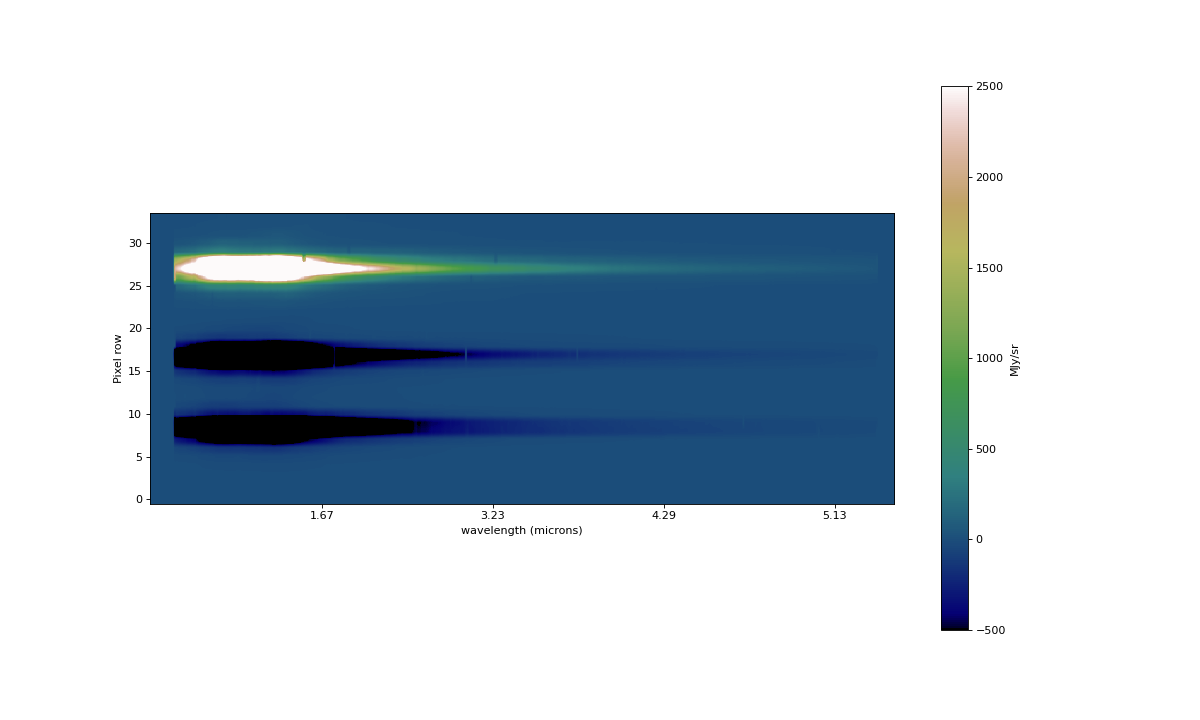

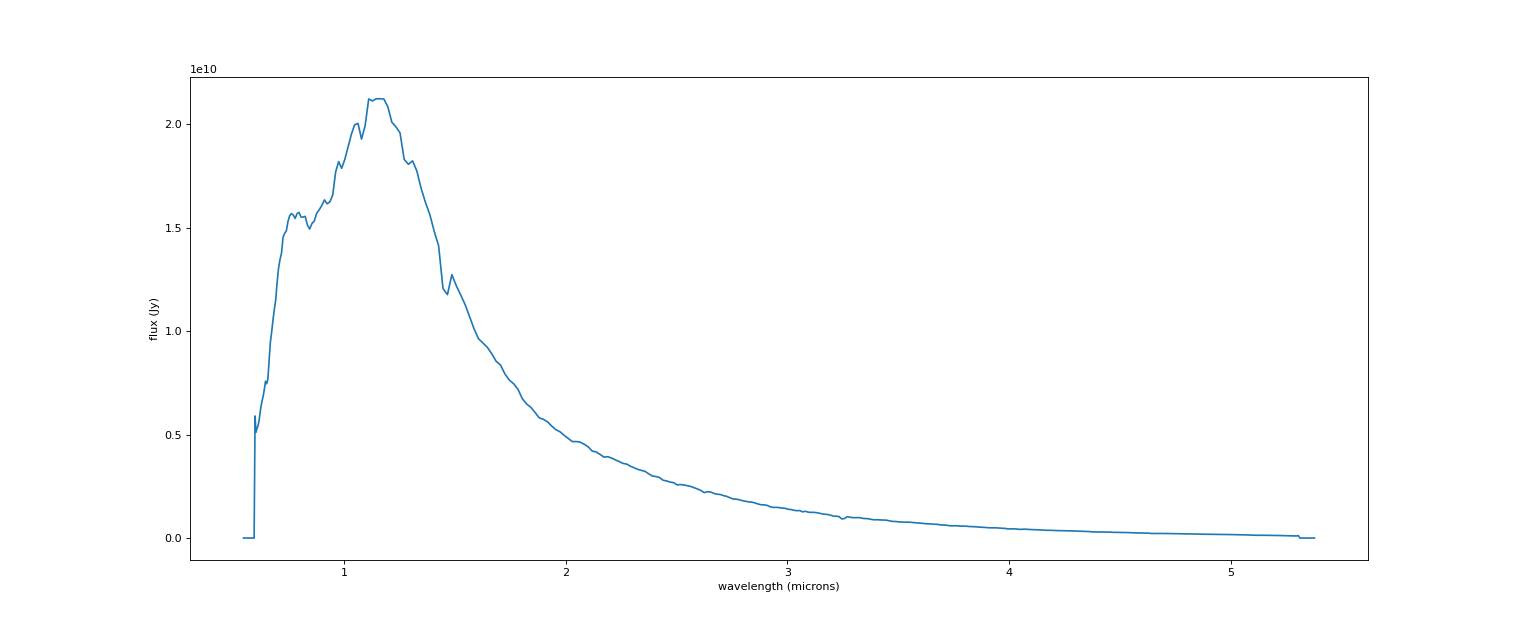

./nirspec_files/nirspec_fssim_d2_cal.fits
S200A1


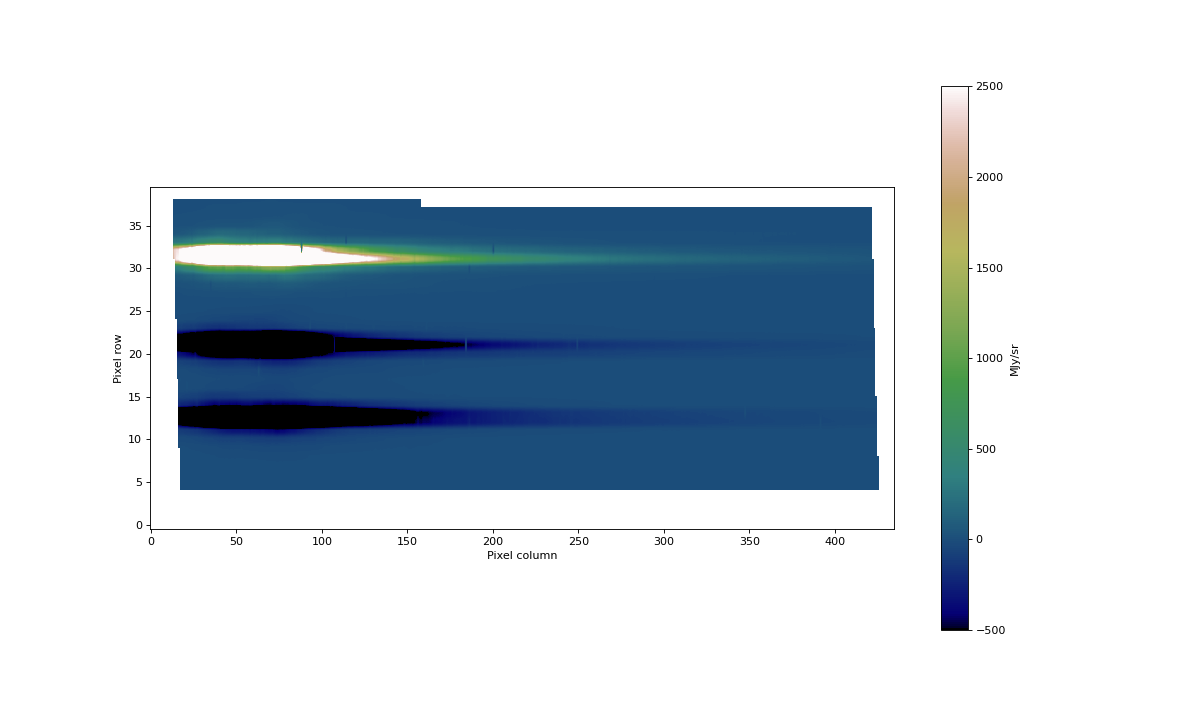

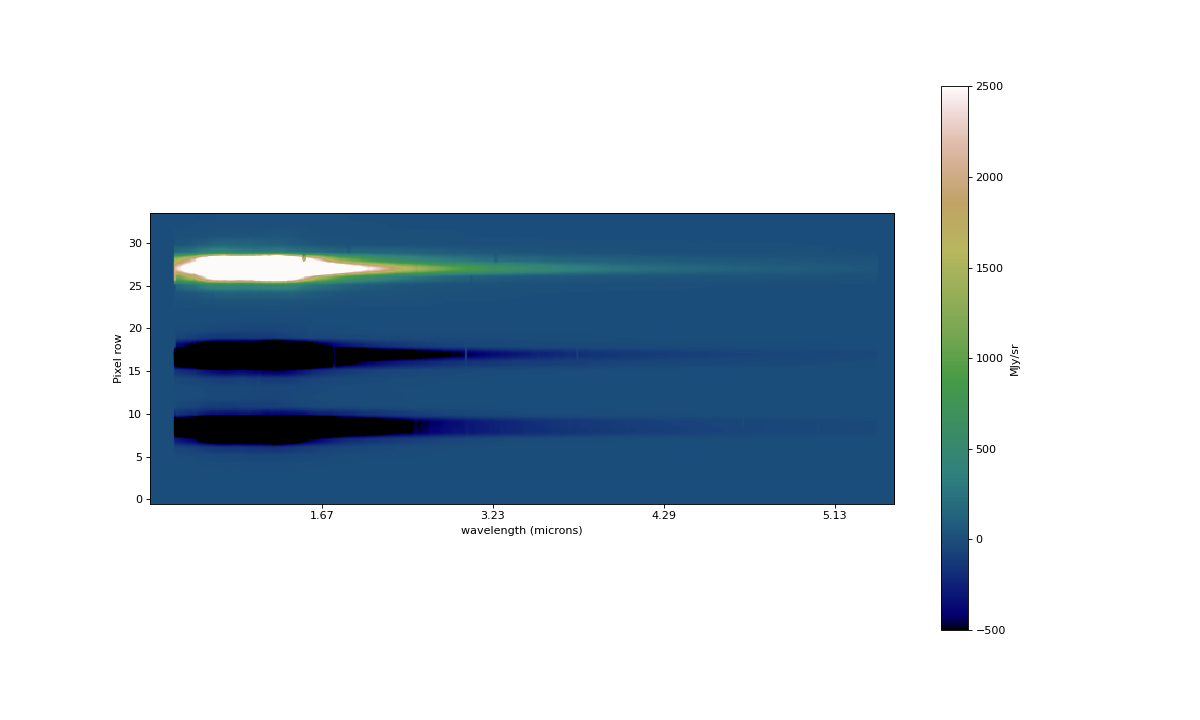

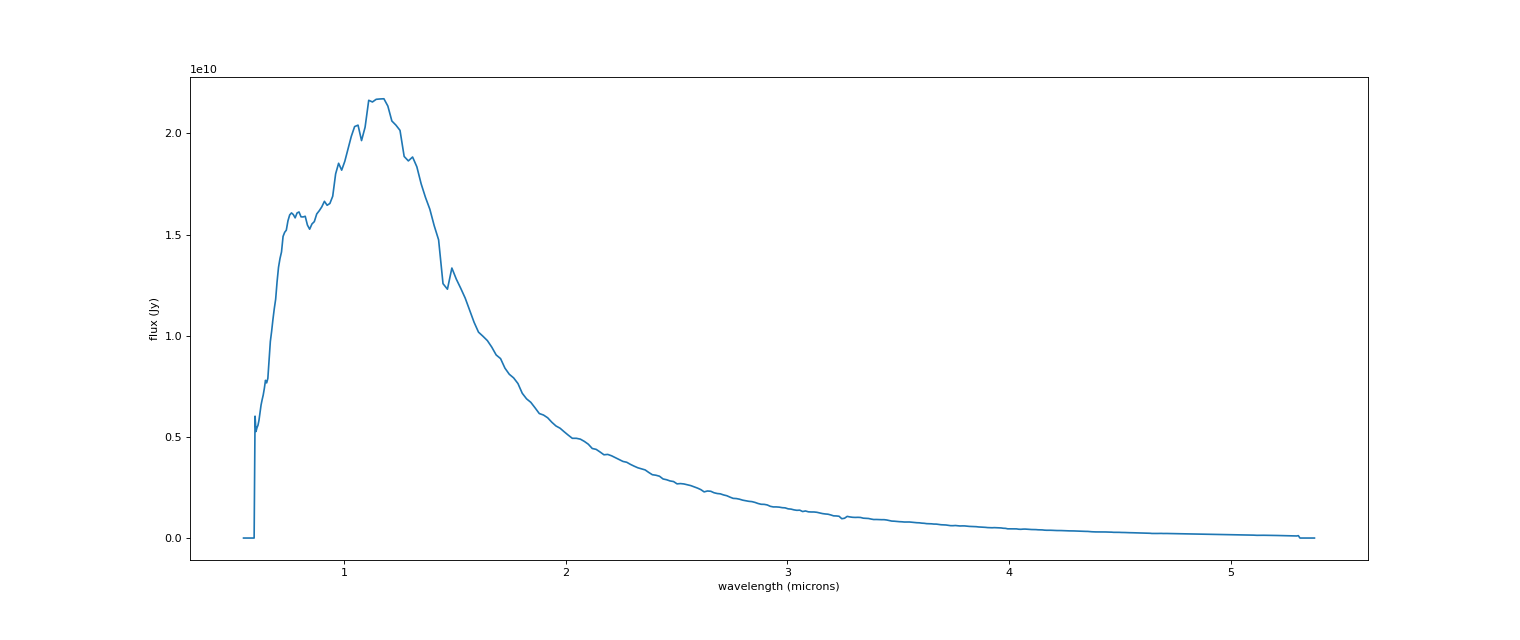

./nirspec_files/nirspec_fssim_d3_cal.fits
S200A1


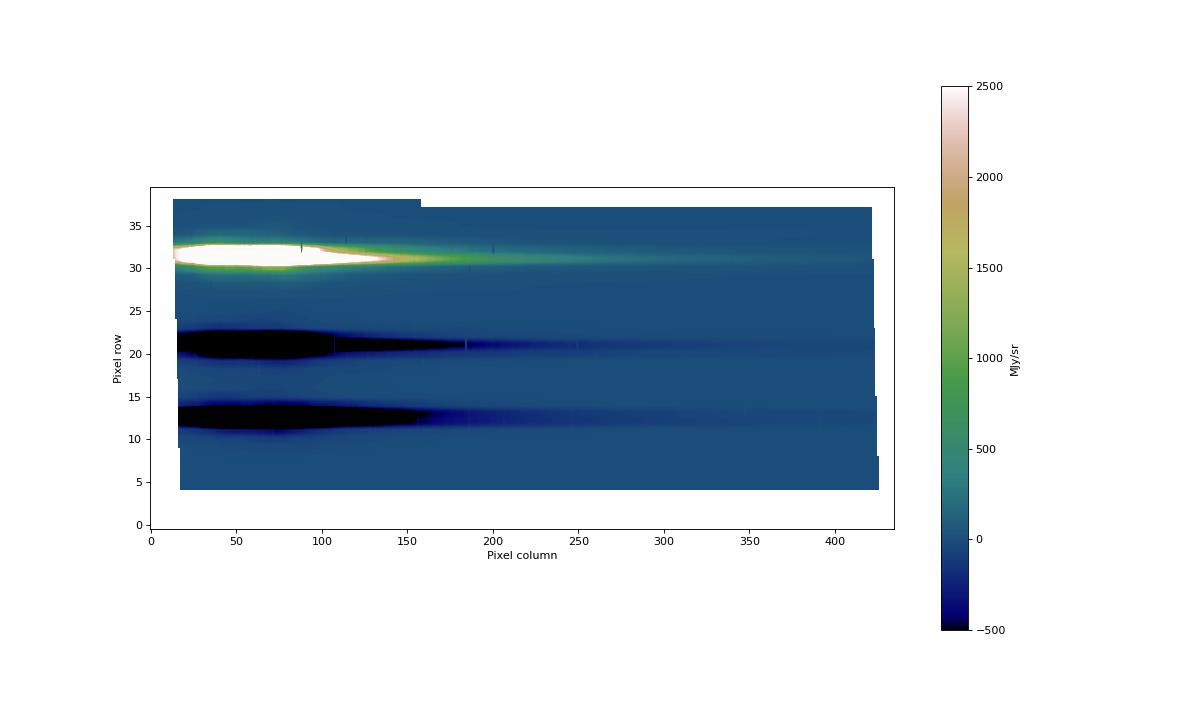

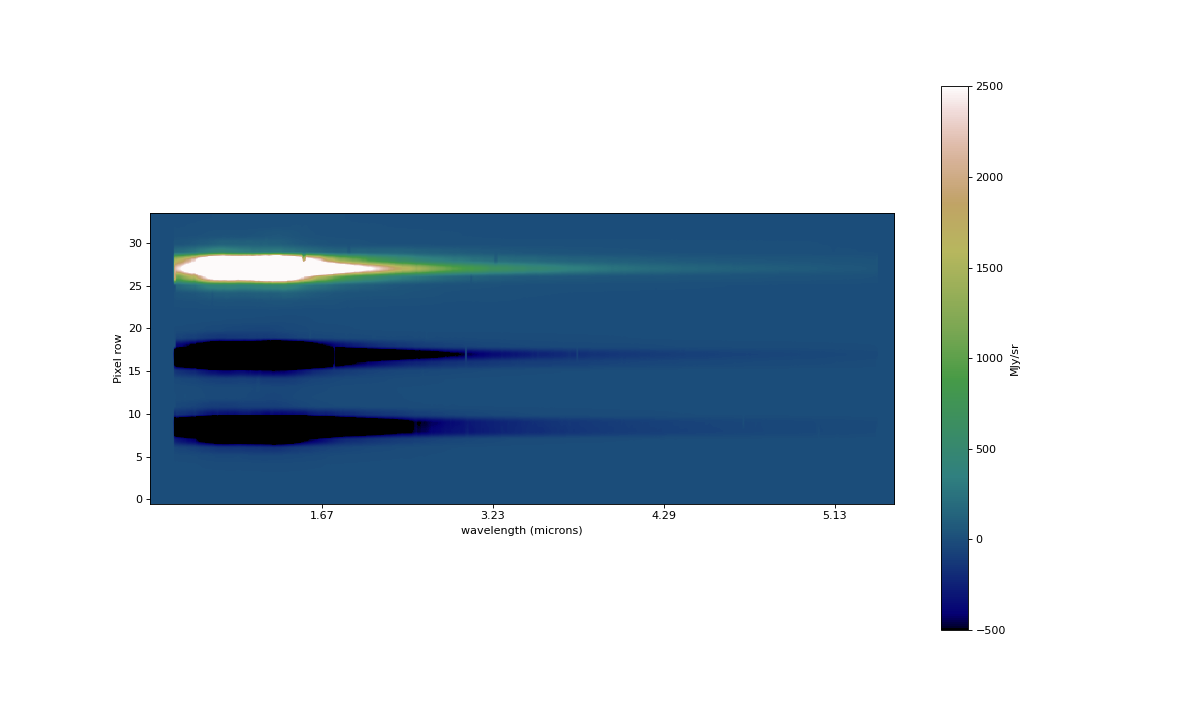

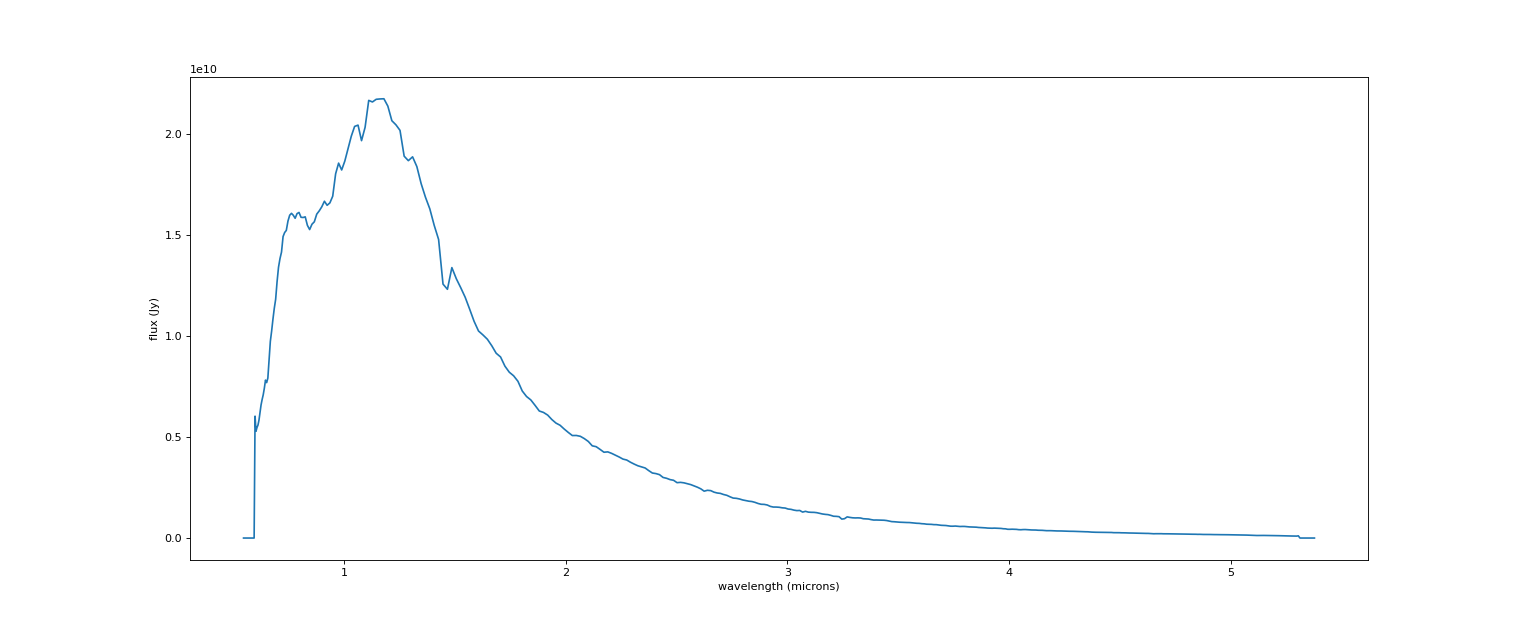

./nirspec_files/nirspec_fssim_d4_cal.fits
S200A1


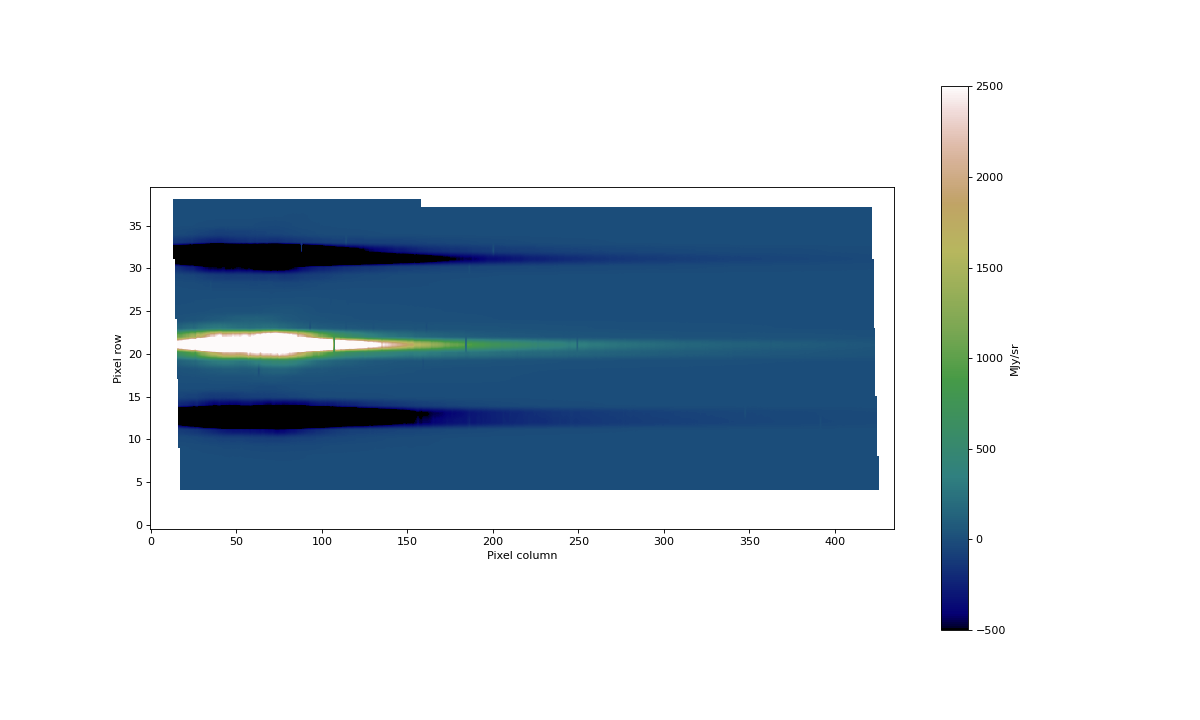

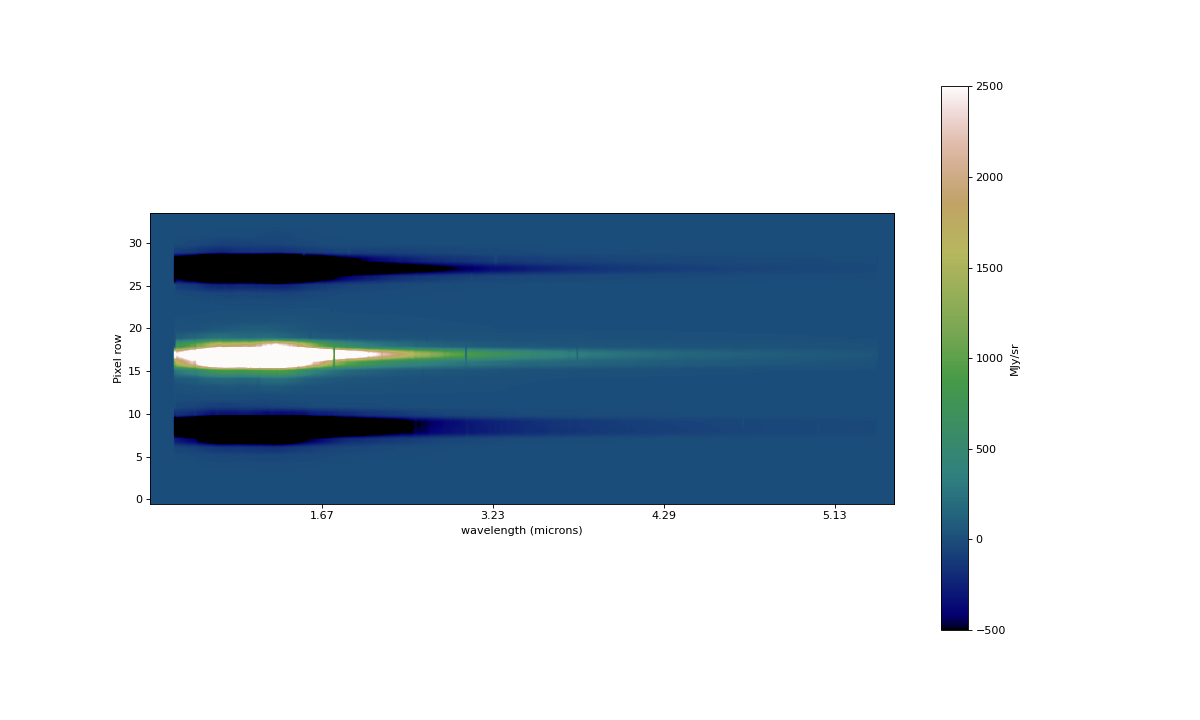

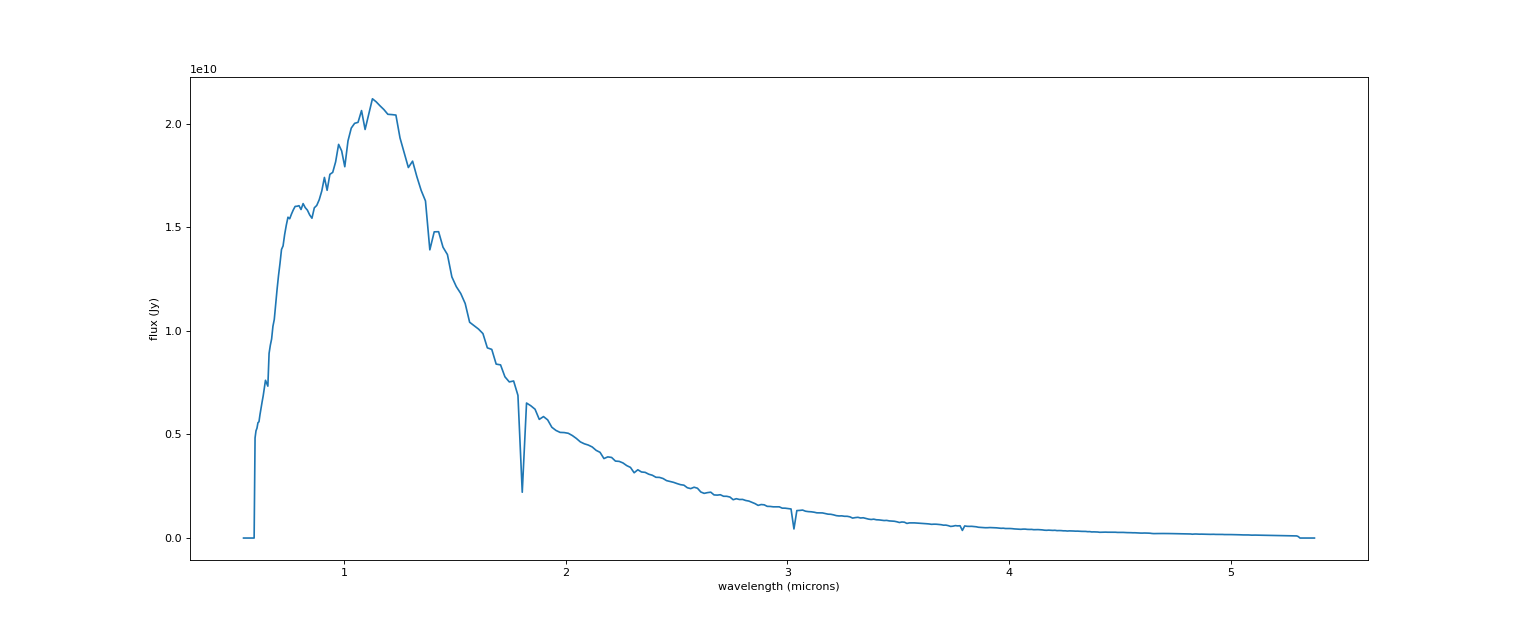

./nirspec_files/nirspec_fssim_d5_cal.fits
S200A1


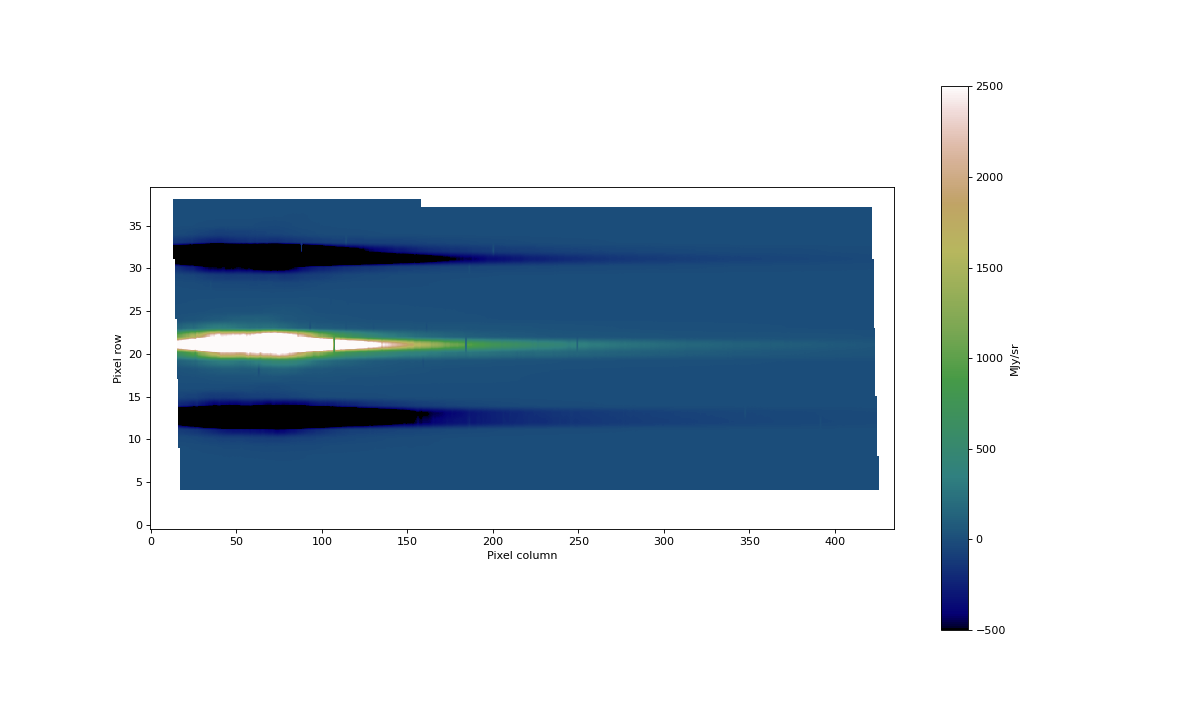

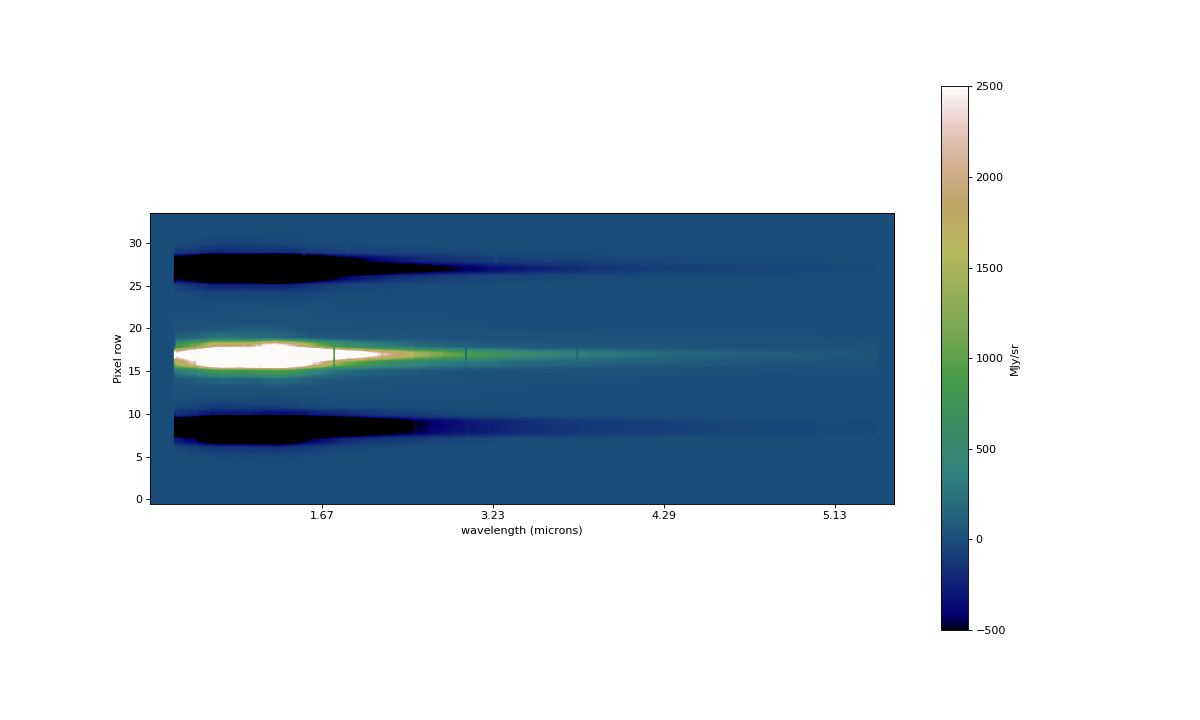

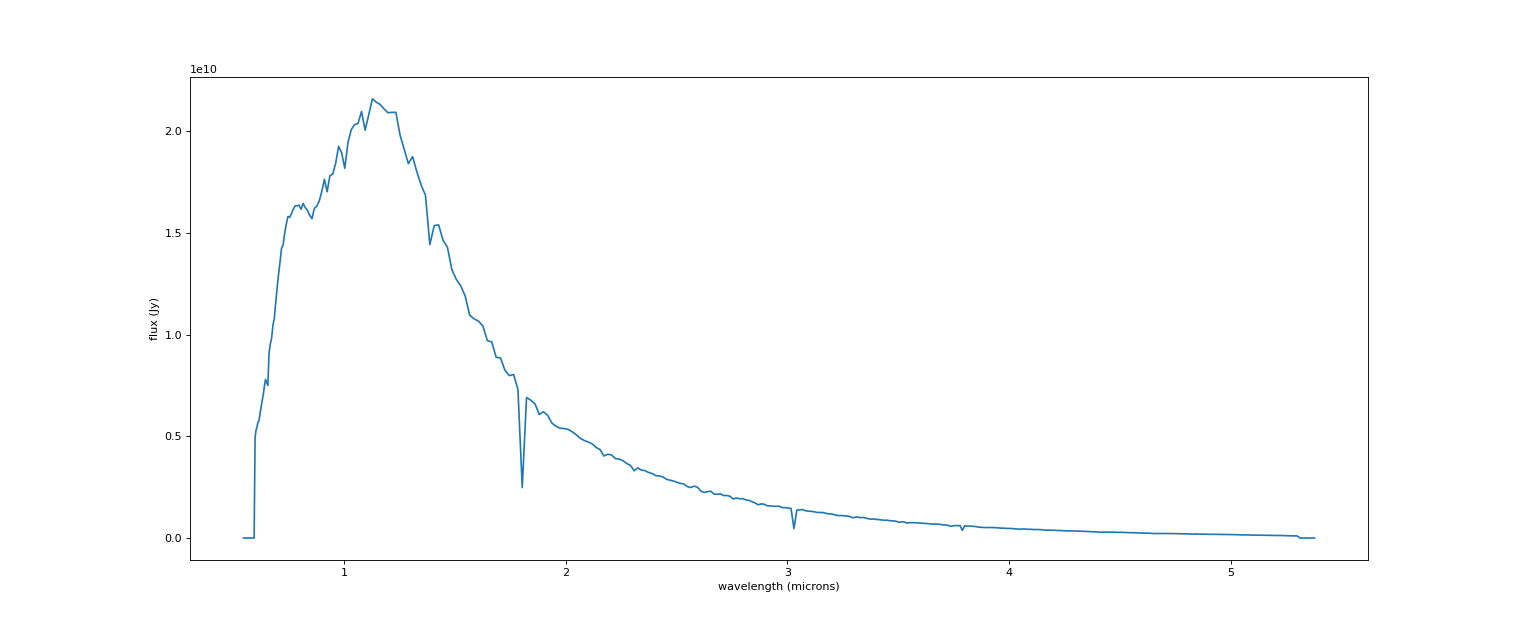

./nirspec_files/nirspec_fssim_d6_cal.fits
S200A1


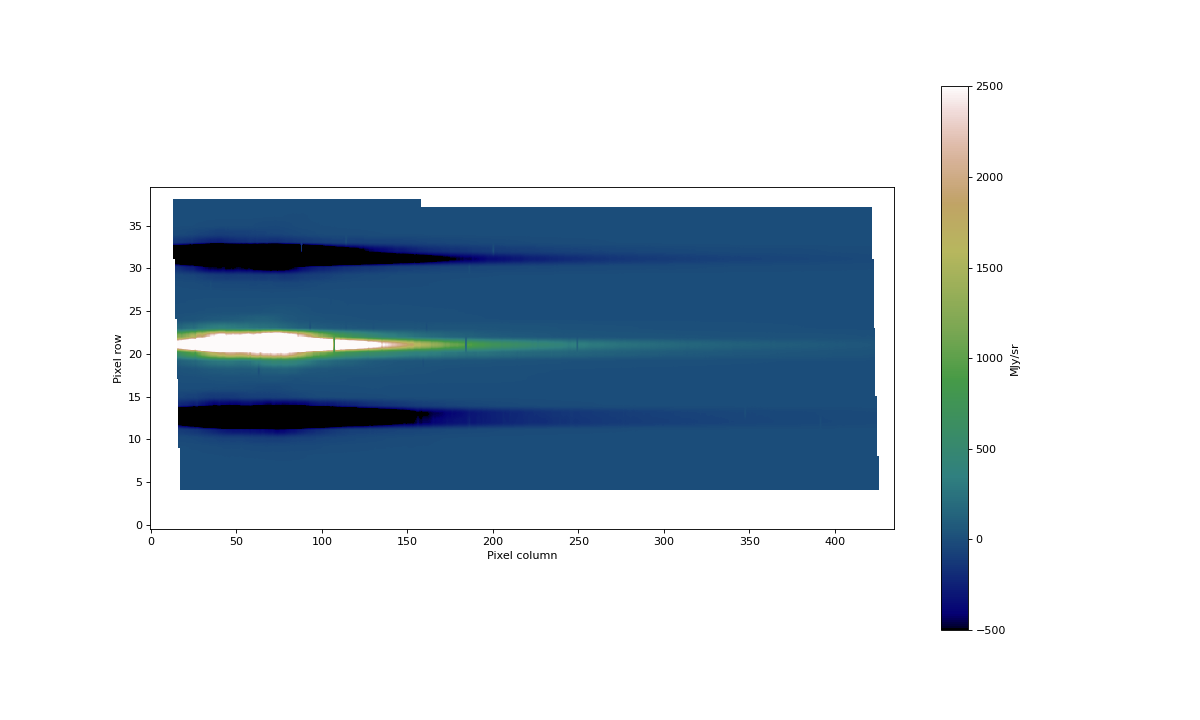

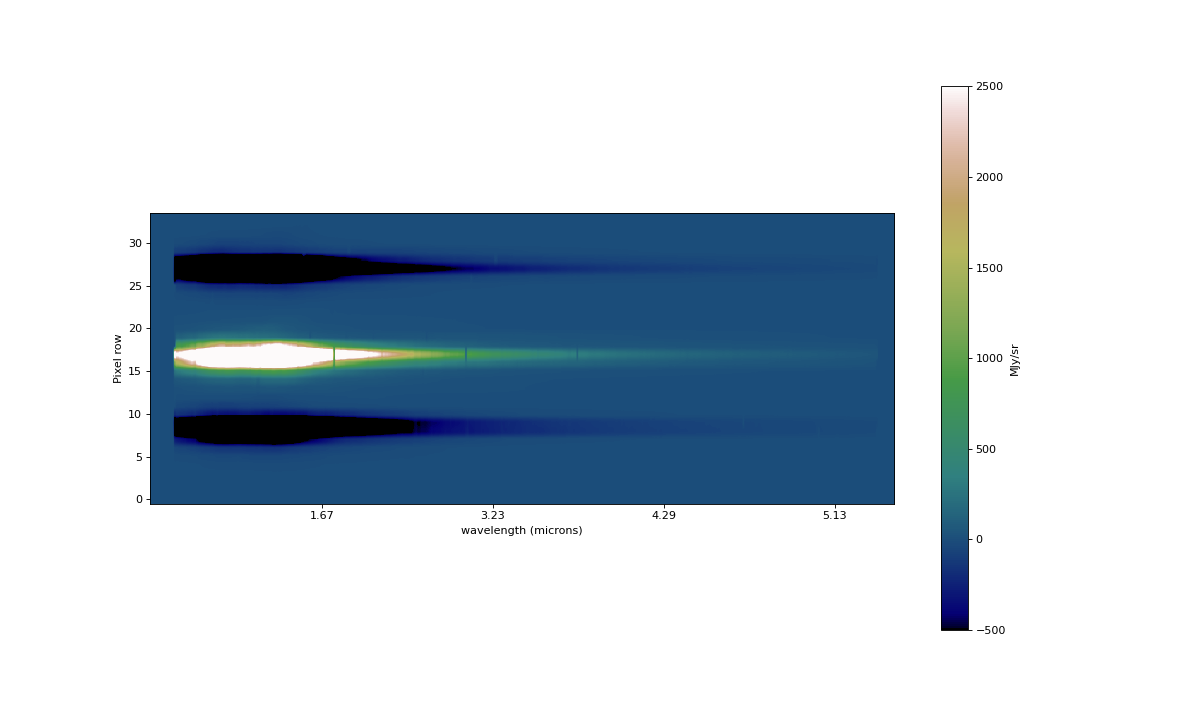

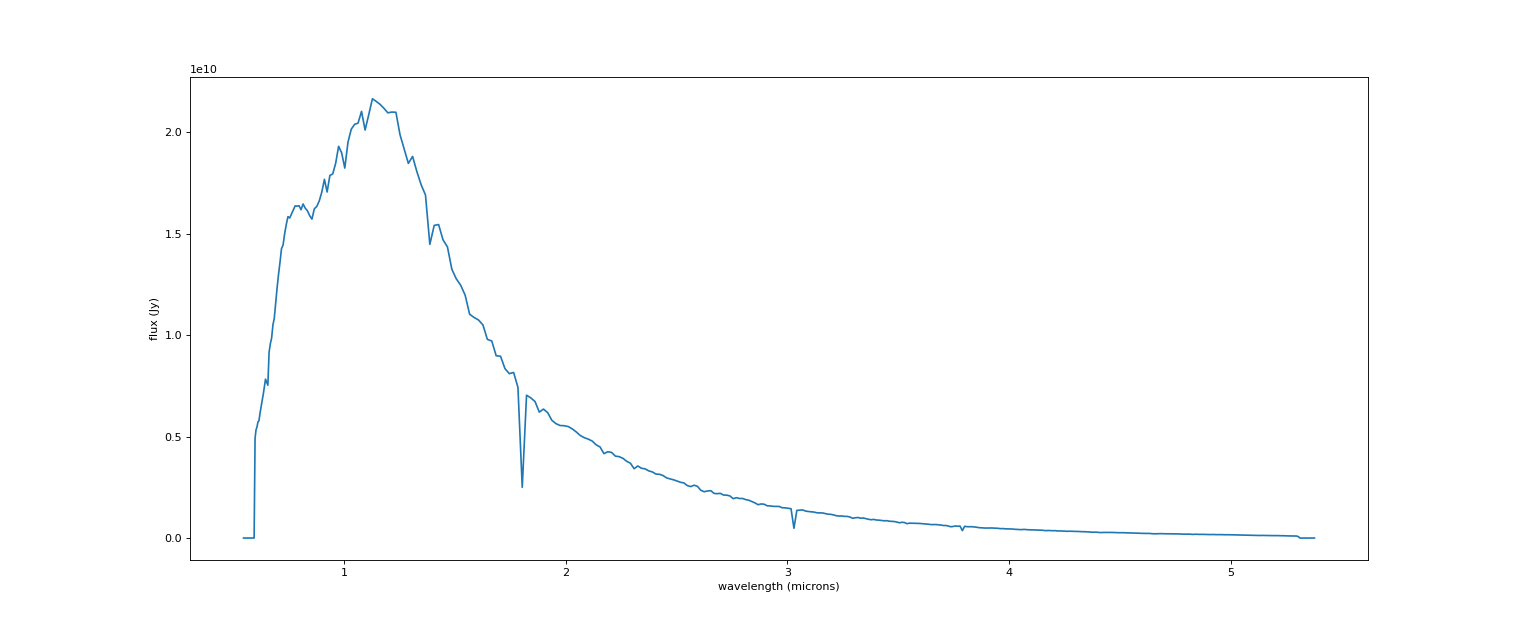

./nirspec_files/nirspec_fssim_d7_cal.fits
S200A1


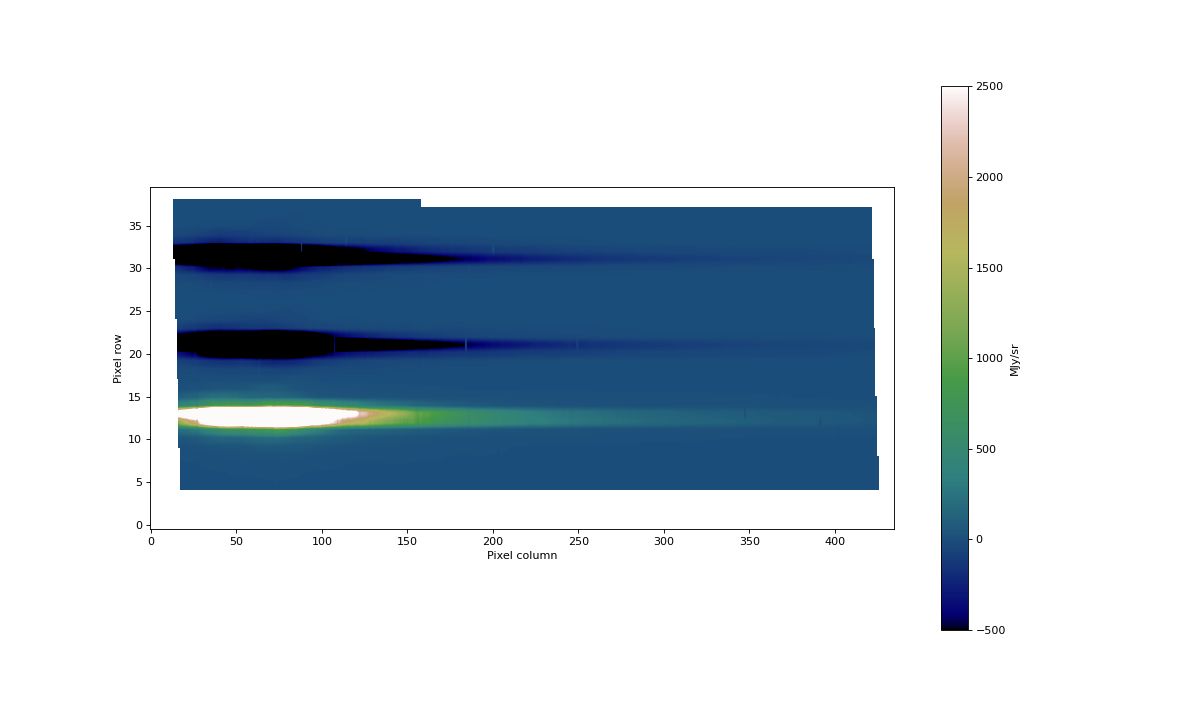

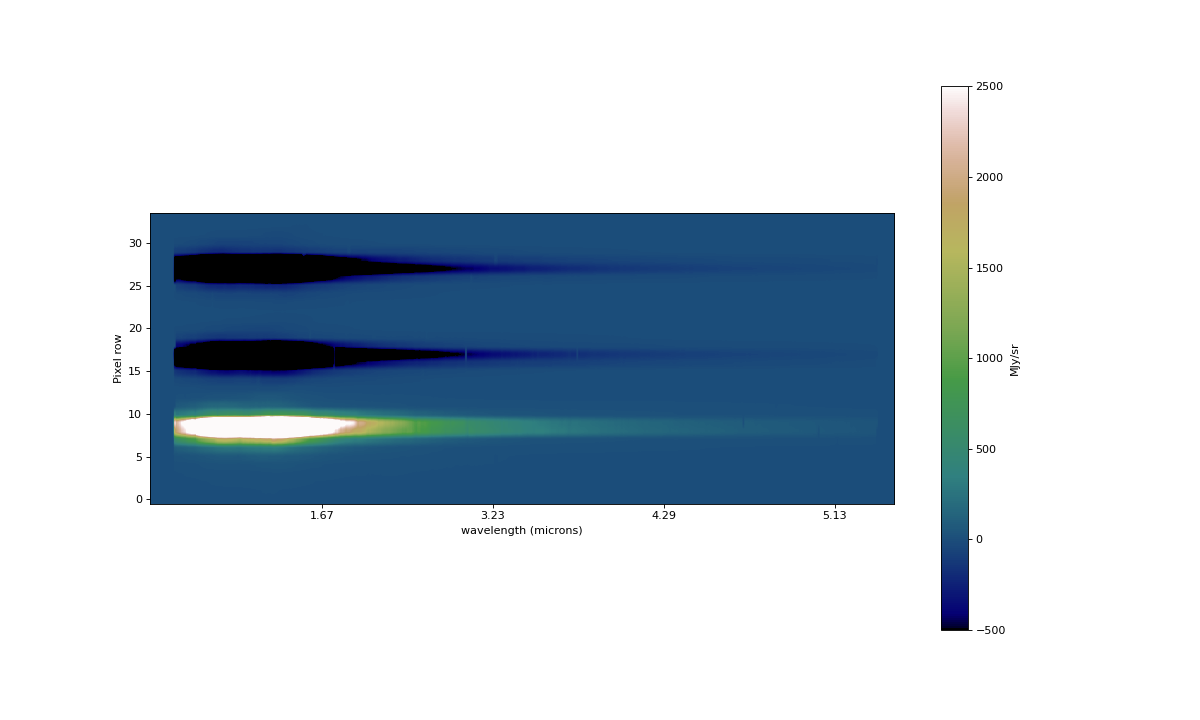

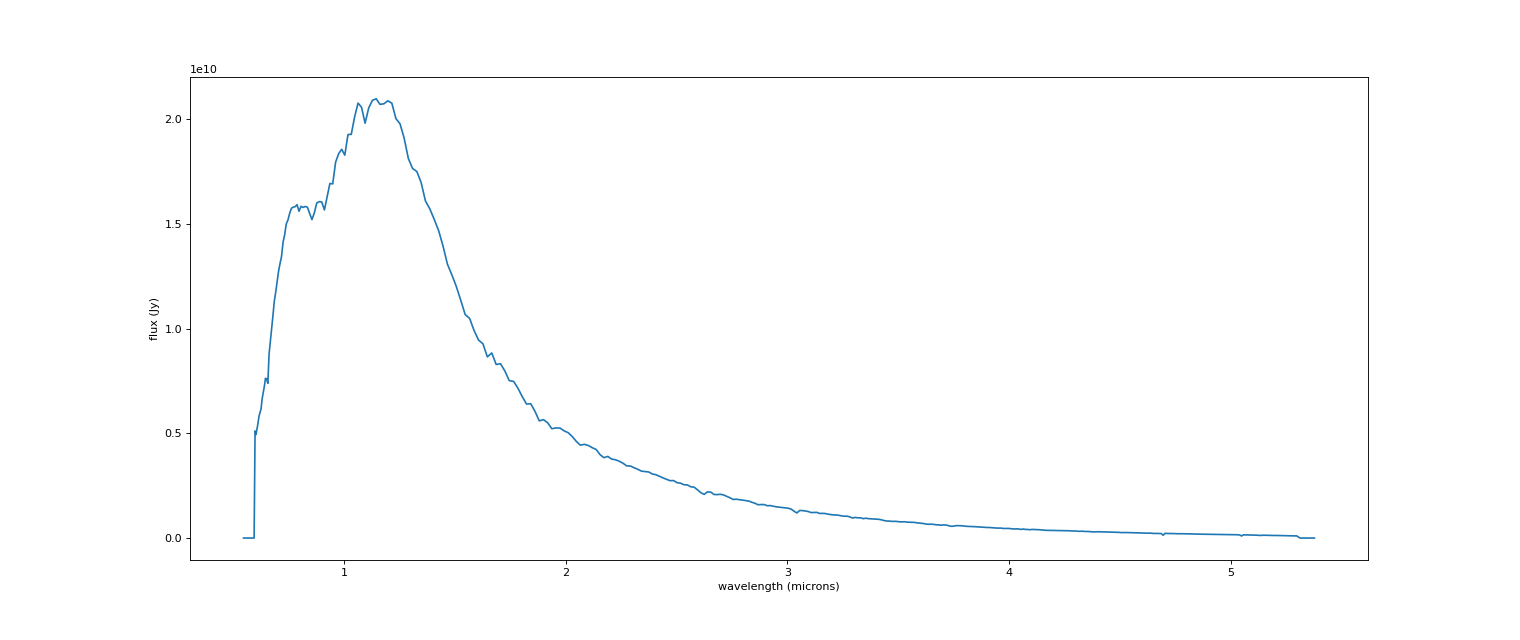

./nirspec_files/nirspec_fssim_d8_cal.fits
S200A1


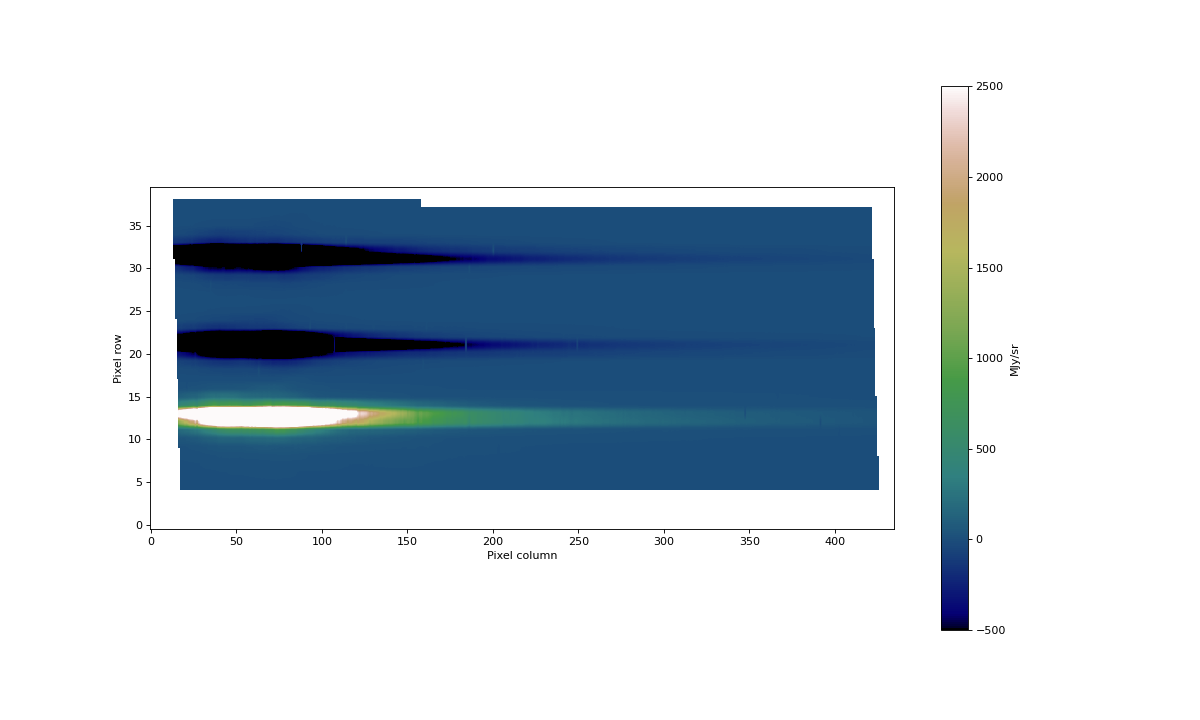

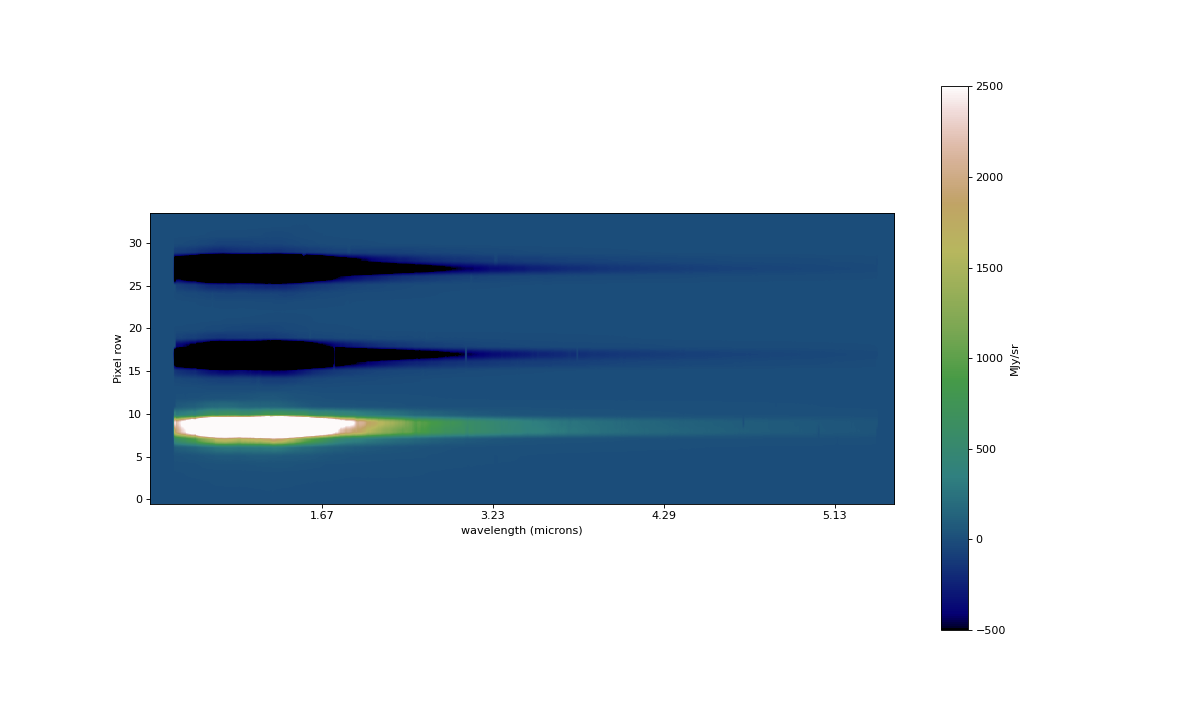

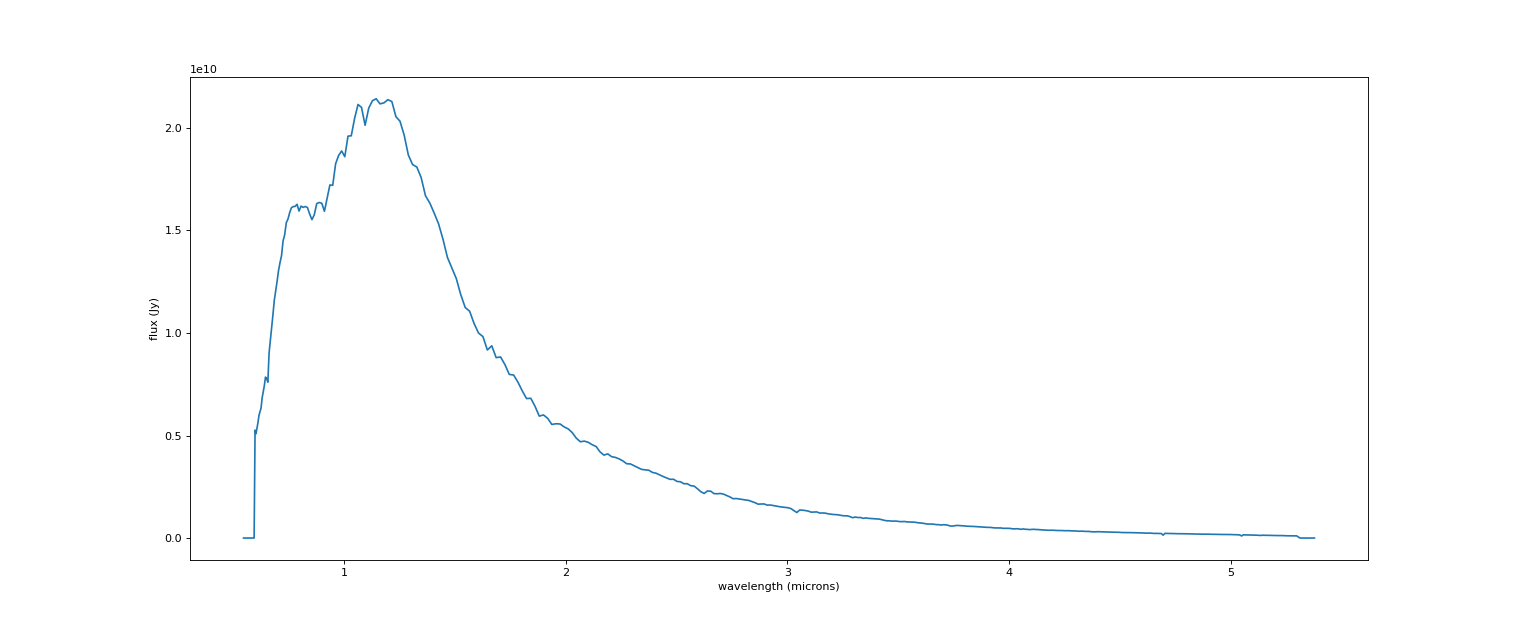

./nirspec_files/nirspec_fssim_d9_cal.fits
S200A1


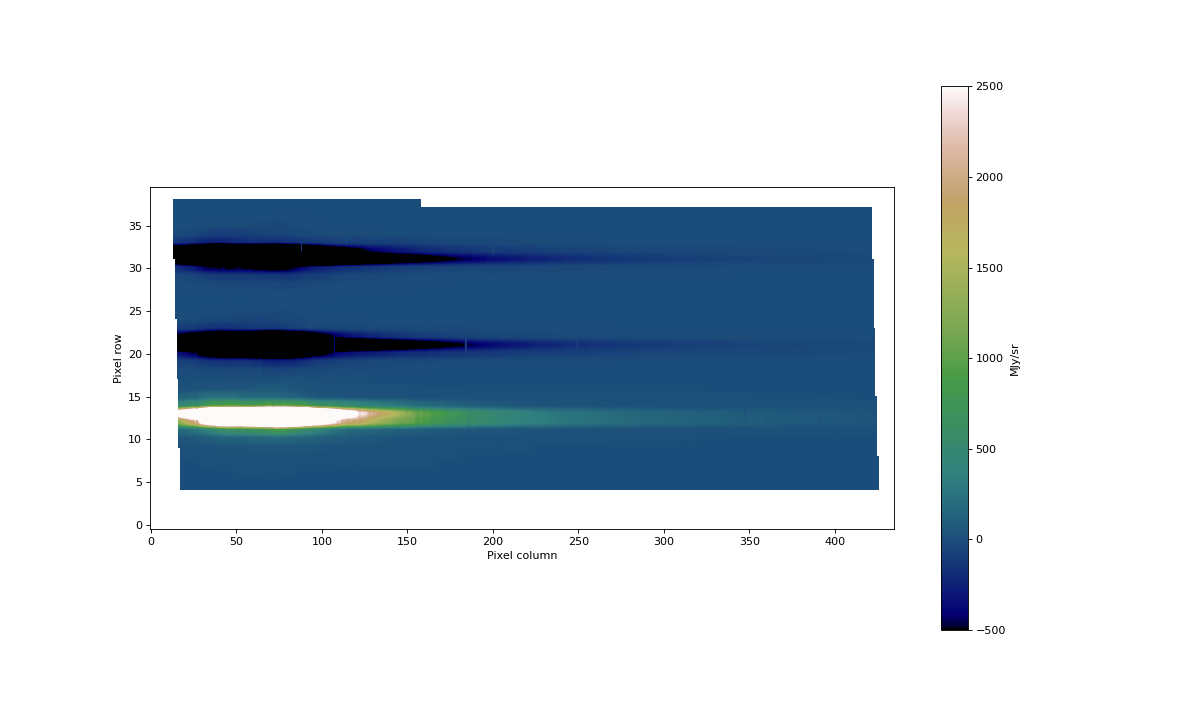

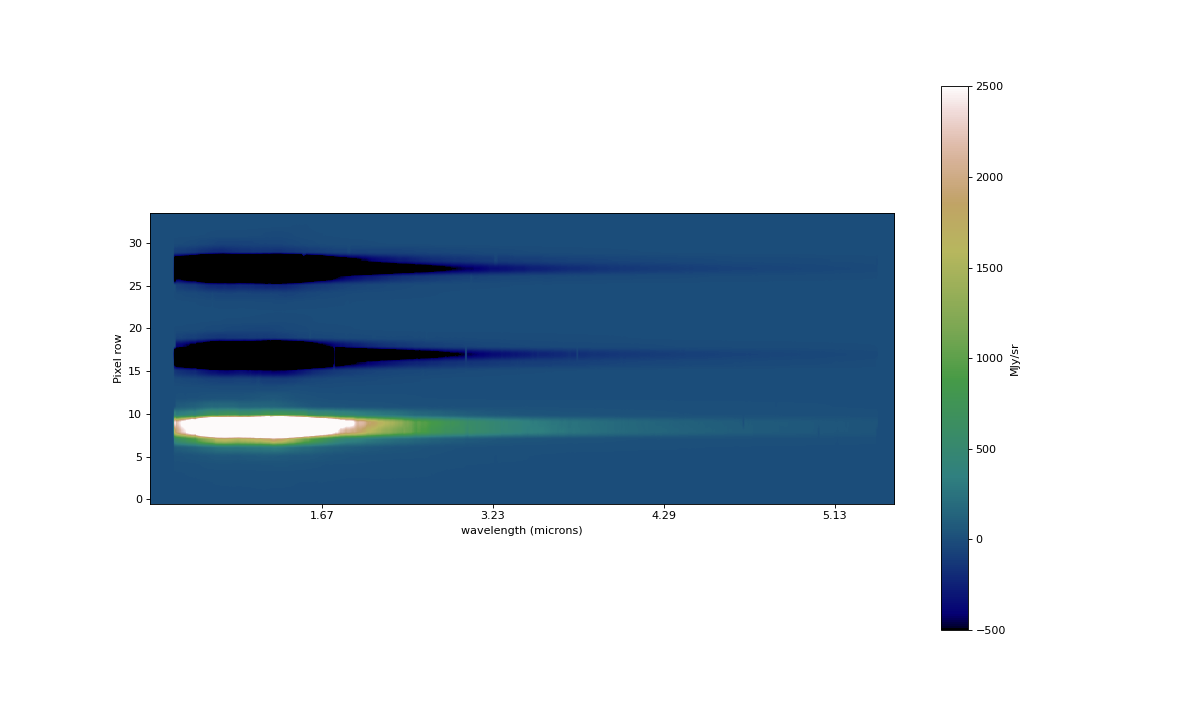

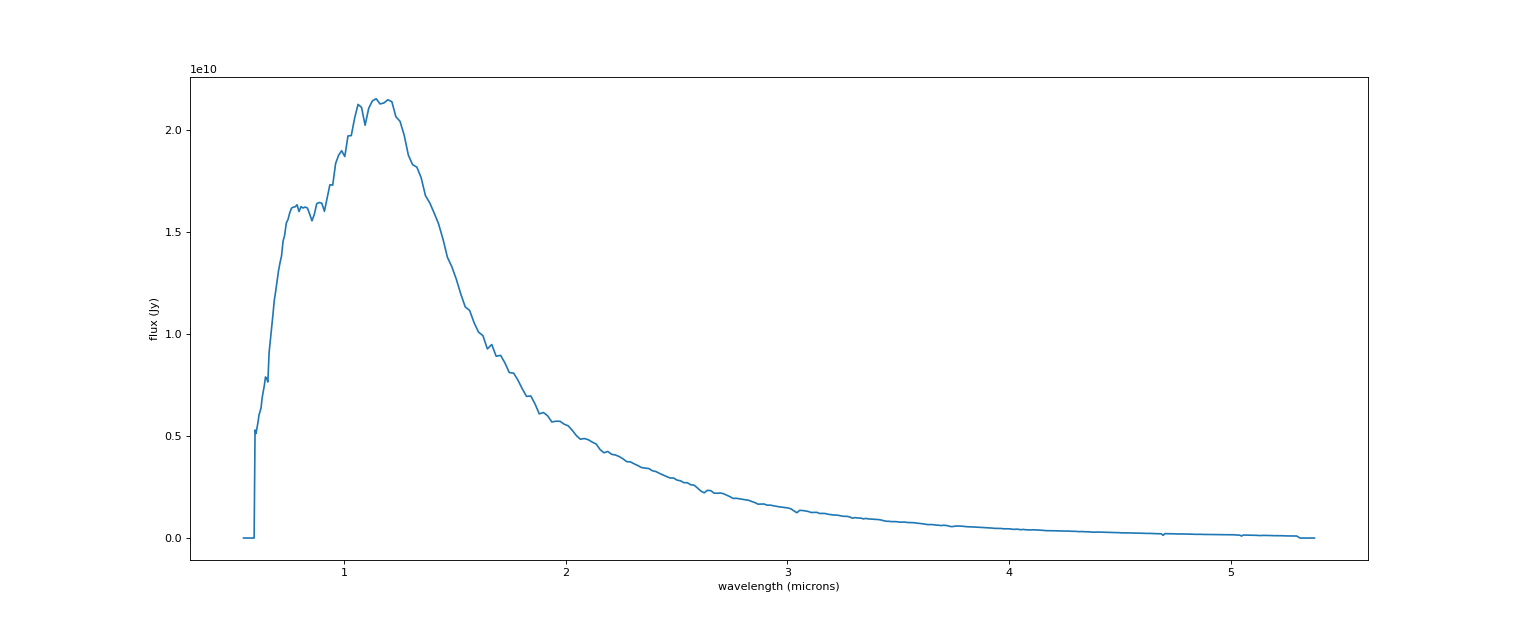

./nirspec_files/nirspec_fssim_s00001_nirspec_clear-prism-s200a1-subs200a1_cal.fits


In [24]:
# take a look at the results - open the level 2b files

callist = [f for f in glob.glob(output_dir+"*cal.fits")]
callist.sort()
for calfile in callist:
    print(calfile)
    cal = datamodels.open(calfile) # this contains the calibrated unrectified 2D spectrum
    root = calfile[:-9]
    s2d = datamodels.open(root+'_s2d.fits')  # this contains the calibrated *rectified* 2D spectrum
    x1d = datamodels.open(root+'_x1d.fits')  # this contains the aperture-extracted 1D spectrum
    
    for slit in cal.slits:
        # this data model is set up to handle multiple slits, which is mainly needed for MOS and WFSS data
        # in this case, there is only one slit, S200A1
        print(slit.name)
        
        calsci = slit.data  # contains the pixel data from the cal file (SCI extension)
        s2dsci = s2d.slits[0].data  # contains the pixel data from the s2d file
    
        # determine the wavelength scale of the s2d data for plotting purposes
        # get the data model WCS object
        wcsobj = s2d.slits[0].meta.wcs
        y, x = np.mgrid[:s2dsci.shape[0], : s2dsci.shape[1]]  # grid of pixel x,y indices
        det2sky = wcsobj.get_transform('detector','world')  # the coordinate transform from detector space (pixels) to sky (RA, DEC in degrees)
        ra, dec, s2dwave = det2sky(x,y)  # RA, Dec, wavelength (microns) for each pixel
        s2dwaves = s2dwave[0,:]  # only need a single row of values since this is the rectified spectrum
        xtint = np.arange(100,s2dsci.shape[1],100)
        xtlab = np.round(s2dwaves[xtint],2)  # wavelength labels for the x-axis
        
        # get wavelength & flux from the x1d data model
        x1dwave = x1d.spec[0].spec_table.WAVELENGTH
        x1dflux = x1d.spec[0].spec_table.FLUX
        
        show_image(calsci,-5.e2,2.5e3,aspect=5.,scale='linear')
        
        show_image(s2dsci,-5.e2,2.5e3,aspect=5.,scale='linear')
        plt.xticks(xtint,xtlab)
        plt.xlabel('wavelength (microns)')
        
        fig = plt.figure(figsize=(19,8))
        plt.plot(x1dwave,x1dflux)
        plt.xlabel('wavelength (microns)')
        plt.ylabel('flux (Jy)')
        plt.show()

now let's do some cool tricks with the data model WCS

2021-06-03 10:28:31,561 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

2021-06-03 10:28:32,074 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



catalog RA,DEC: 90.75416666666666 -70.77527777777777


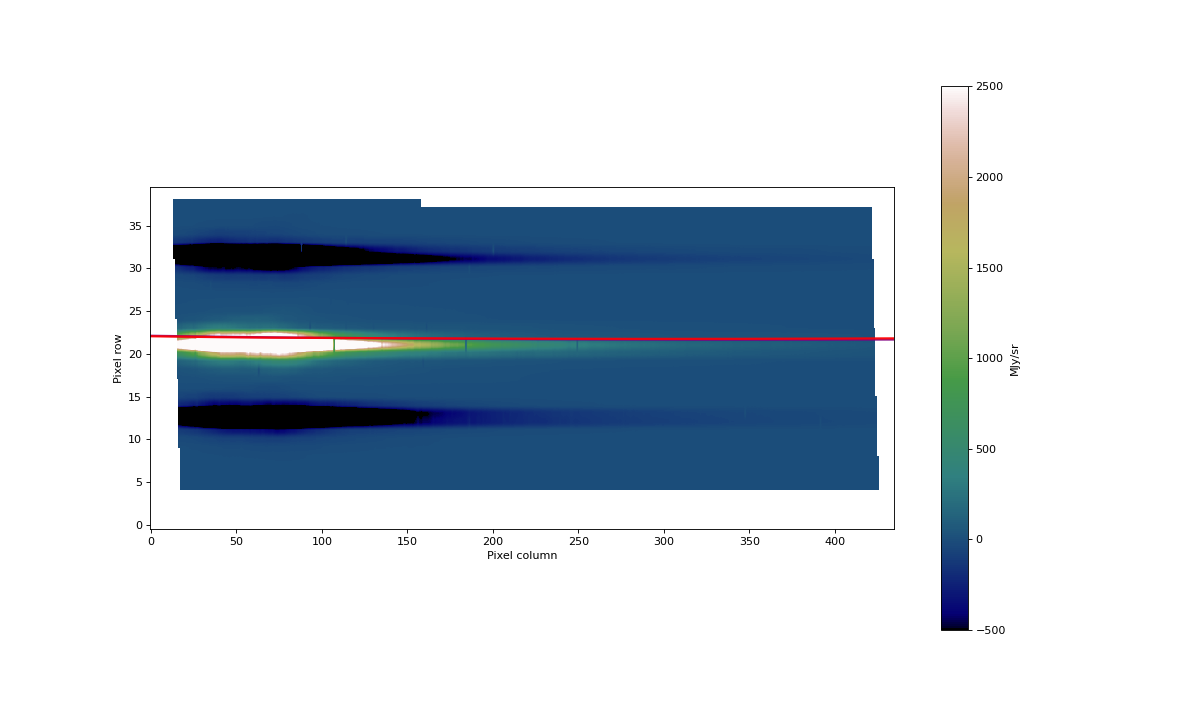

In [26]:
# choose one of the cal files
calfile = output_dir+'nirspec_fssim_d5_cal.fits'
cal = datamodels.open(calfile)

# get the WCS object
wcsobj = cal.slits[0].meta.wcs

# using coordinate transforms embedded in the WCS object,
# we can calculate wavelength and sky coordinates for each pixel in the 2D spectrum
y, x = np.mgrid[:cal.slits[0].data.shape[0], : cal.slits[0].data.shape[1]]
det2sky = wcsobj.get_transform('detector','world')  # this is the transform from detector space (pixel coordinates) to the sky (RA, Dec in degrees)
calra, caldec, calwave = det2sky(x,y)
calwaves = calwave[0,:] # get the set of wavelength values for the first pixel row, for later use

# get the source RA and Dec coordinates from the metadata (also located in the header of the fits SCI extension)
source_ra = slit.meta.target.ra
source_dec = slit.meta.target.dec
print('catalog RA,DEC:',source_ra,source_dec)
        
# find the trace of the source coordinates
calxm = np.arange(calra.shape[1])
calym = np.arange(calra.shape[0])
calym_ra = np.zeros(calra.shape[1])
calym_dec = np.zeros(calra.shape[1])
for j in range(len(calxm)):
    col = calra[:,j]
    calym_ra[j] = np.interp(source_ra,col[np.isfinite(col)],calym[np.isfinite(col)])
    col = caldec[:,j]
    calym_dec[j] = np.interp(source_dec,col[np.isfinite(col)],calym[np.isfinite(col)])
    
# plot
show_image(cal.slits[0].data,-5.e2,25.e2,aspect=5.,scale='linear')
plt.plot(calxm,calym_ra,color='purple',alpha=0.9,linewidth=2)
plt.plot(calxm,calym_dec,color='red',alpha=0.9,linewidth=2)

## Run individual steps of the spec2 pipeline <a id='runspec2steps'></a>

Now let's try running individual pipeline steps on a single exposure, and taking a look at their output to give a flavor for what they are doing to the data...

### assign_wcs <a id='awcs'></a>

This is a complex step that generates tranfsorms between various instrument optical planes and the sky, using the NIRSpec instrument model with multiple reference files.

In [27]:
filename = output_dir+'nirspec_fssim_d5_rate.fits'  # an input level 2a file
root = filename[:-9]  # for later matching
print(root)

step = AssignWcsStep()
step.save_results = True
step.output_dir = output_dir
result = step(filename)

2021-06-03 10:32:11,120 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

2021-06-03 10:32:11,132 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2021-06-03 10:32:11,499 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('./nirspec_files/nirspec_fssim_d5_rate.fits',).


./nirspec_files/nirspec_fssim_d5_


2021-06-03 10:32:11,502 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './nirspec_files/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2021-06-03 10:32:13,912 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.0333843045 deg
2021-06-03 10:32:13,912 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.336739093065 deg
2021-06-03 10:32:13,913 - stpipe.AssignWcsStep - INFO - theta_y correction: 0.0 deg
2021-06-03 10:32:13,915 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg
2021-06-03 10:32:19,231 - stpipe.AssignWcsStep - INFO - Slits projected on detector NRS1: ['S200A1']
2021-06-03 10:32:1

Note the verbose output prints the values of various instrument parameters that are relevant for the construction of the instrument transforms, such as the grating wheel tilt and the slit (or slits, in the case of MOS) used for the exposure.  In this demo, a fixed slit was used, which is indicated here by "quadrant 5"; if this had been a MOS exposure, there would be multiple slits indicated in any or all of quadrants 1-4.

In [28]:
# The output file has the suffix _assignwcsstep appended:
awcs_output_file = root+'assignwcsstep.fits'
print(awcs_output_file)

# load the output into a data model container
awcs = datamodels.open(awcs_output_file)
awcs

2021-06-03 10:32:40,807 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



./nirspec_files/nirspec_fssim_d5_assignwcsstep.fits


<ImageModel(64, 2048) from nirspec_fssim_d5_assignwcsstep.fits>

In [29]:
# get the WCS information populated by the algorithms of the assign_wcs step
wcsobj = awcs.meta.wcs
#wcsobj

2021-06-03 10:32:49,989 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



In [30]:
# list the frames of reference available for transformation
wcsobj.available_frames

['detector',
 'sca',
 'gwa',
 'slit_frame',
 'msa_frame',
 'oteip',
 'v2v3',
 'v2v3vacorr',
 'world']

In [31]:
# examples of the units for some of these frames
print(wcsobj.detector.unit) # xy pixel indices
print(wcsobj.slit_frame.unit)  # relative xy position in the slit aperture
print(wcsobj.msa_frame.unit)  # absolute xy position in the slit aperture
print(wcsobj.world.unit)  # RA, Dec sky position

(Unit("pix"), Unit("pix"))
(Unit(dimensionless), Unit(dimensionless), Unit("um"))
(Unit("m"), Unit("m"), Unit("um"))
(Unit("deg"), Unit("deg"), Unit("um"))


These correspond to image and pupil planes in the instrument, including the detector, the grating wheel, the slit aperture, and various sky planes.  One can transform between any two of these using the appropriate transformation.

In [32]:
# show an example?  or make this an exercise based on the cell above that used the cal product?

### background <a id='background'></a>

If there are associated exposures to be used as backgrounds (as in a nod set), this step will average them (if more than one), and then directly subtract from the exposure being processed.

In [33]:
filename = root+'assignwcsstep.fits'  # the output from the previous step

backgrounds = [output_dir+'nirspec_fssim_d2_rate.fits',output_dir+'nirspec_fssim_d8_rate.fits']
# these exposures are for the middle spectral dither positions at primary dither positions 1 and 3

step = BackgroundStep()
step.save_results = True
step.output_dir = output_dir
result = step(filename,backgrounds)

2021-06-03 10:33:47,686 - stpipe.BackgroundStep - INFO - BackgroundStep instance created.
2021-06-03 10:33:47,898 - stpipe.BackgroundStep - INFO - Step BackgroundStep running with args ('./nirspec_files/nirspec_fssim_d5_assignwcsstep.fits', ['./nirspec_files/nirspec_fssim_d2_rate.fits', './nirspec_files/nirspec_fssim_d8_rate.fits']).
2021-06-03 10:33:47,900 - stpipe.BackgroundStep - INFO - Step BackgroundStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './nirspec_files/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sigma': 3.0, 'maxiters': None}
2021-06-03 10:33:49,017 - stpipe.BackgroundStep - INFO - Saved model in ./nirspec_files/nirspec_fssim_d5_backgroundstep.fits
2021-06-03 10:33:49,018 - stpipe.BackgroundStep - INFO - Step BackgroundStep done


Look at the output.  Since this step does a direct image-to-image subtraction, and the input backgrounds were the "top" and "bottom" primary dither positions, we should see a positive source trace surrounded by negative traces on either side.

2021-06-03 10:33:52,575 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



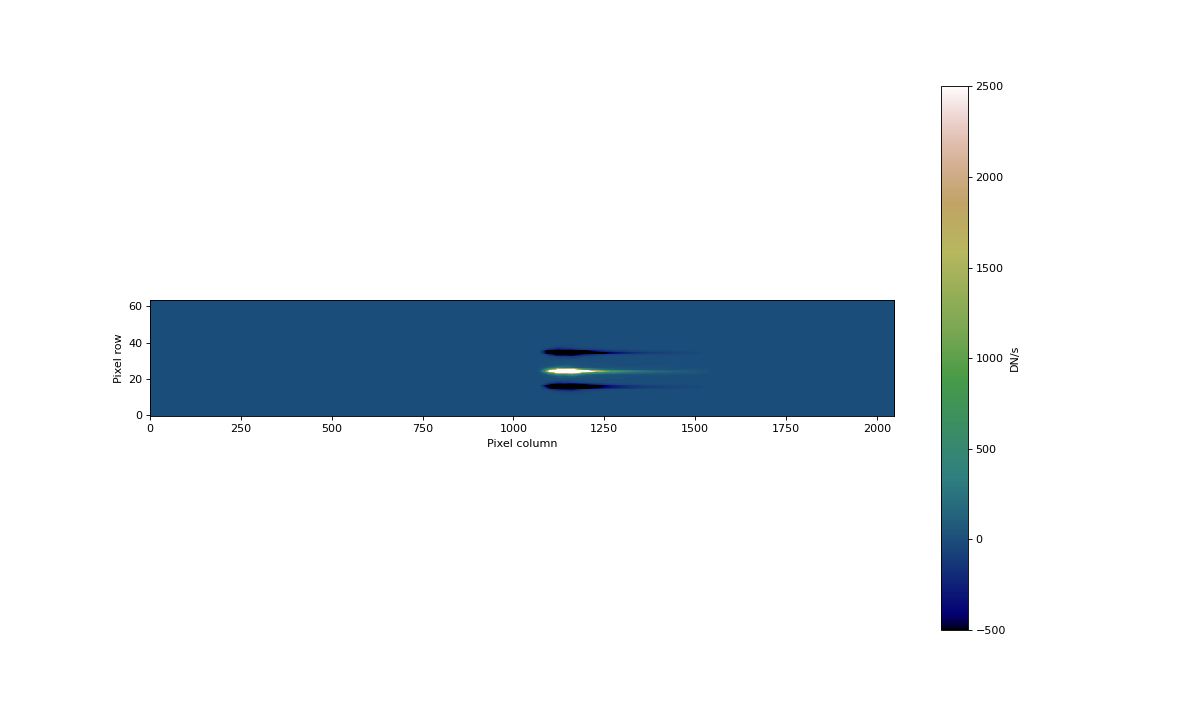

In [34]:
# The output file has the suffix _backgroundstep appended:
bsubfile = root+'backgroundstep.fits'

# load the output into a data model container
bsub = datamodels.open(bsubfile)

# plot the image
show_image(bsub.data,-5.e2,25.e2,aspect=5.,scale='linear',units='DN/s')

### extract_2d <a id='extract2d'></a>

Using the WCS transforms constructed by assign_wcs, this step extracts a 2D "subwindow" from the original full frame or (in this case) subarray image.  For MOS data, there are multiple 2D extractions corresponding to the multiple sources observed in the exposure.

In [35]:
filename = root+'backgroundstep.fits'  # the output from the previous step

step = Extract2dStep()
step.save_results = True
step.output_dir = output_dir
result = step(filename)

2021-06-03 10:33:58,111 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

2021-06-03 10:33:58,115 - stpipe.Extract2dStep - INFO - Extract2dStep instance created.
2021-06-03 10:33:58,225 - stpipe.Extract2dStep - INFO - Step Extract2dStep running with args ('./nirspec_files/nirspec_fssim_d5_backgroundstep.fits',).
2021-06-03 10:33:58,227 - stpipe.Extract2dStep - INFO - Step Extract2dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './nirspec_files/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file':

The bounds of the 2D extraction are printed in the above verbose output as "Subarray x/y-extents".  They are determined based on the expected wavelength and slit projection limits appropriate for the aperture and grating/filter combination being used.

2021-06-03 10:34:07,709 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



./nirspec_files/nirspec_fssim_d5_extract2dstep.fits


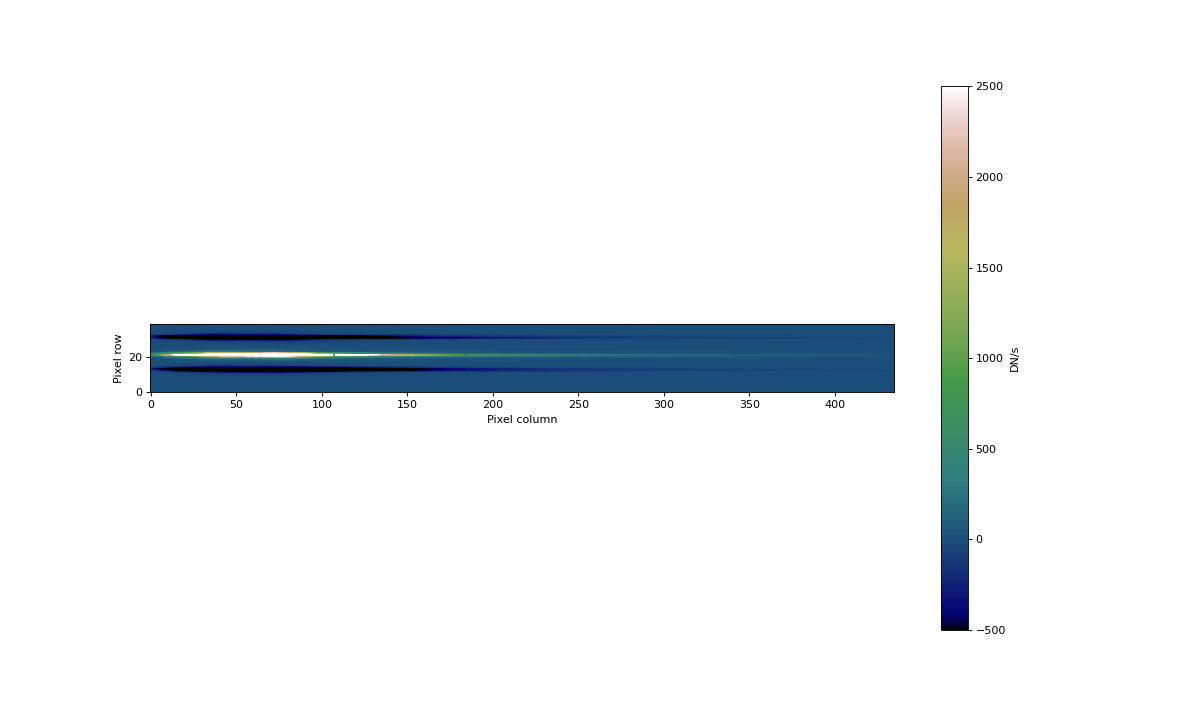

In [36]:
# The output file has the suffix _extract2dstep appended:
e2d_output_file = root+'extract2dstep.fits'
print(e2d_output_file)

# load the output into a data model container
e2d = datamodels.open(e2d_output_file)

# plot the image
show_image(e2d.slits[0].data,-5.e2,25.e2,aspect=1.,scale='linear',units='DN/s')

### sourcetype <a id='srctype'></a>

This step sets the source type (point or extended) based on information passed from PPS (given in the SRCTYAPT header keyword); if no flag was set, by default the type is set to point.  This affects subsequent processing steps, which do different things for each type.

In [37]:
filename = root+'extract2dstep.fits'  # the output from the previous step

step = SourceTypeStep()
step.save_results = True
step.output_dir = output_dir
result = step(filename)

2021-06-03 10:34:14,560 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

2021-06-03 10:34:14,563 - stpipe.SourceTypeStep - INFO - SourceTypeStep instance created.
2021-06-03 10:34:14,707 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep running with args ('./nirspec_files/nirspec_fssim_d5_extract2dstep.fits',).
2021-06-03 10:34:14,708 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './nirspec_files/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_f

keyword SRCTYPE should be set to "POINT" in this case, because PPS database value SRCTYAPT is "UNKNOWN"

In [38]:
# The output file has the suffix _sourcetypestep appended:
stype_output_file = root+'sourcetypestep.fits'

# load the output into a data model container
stype = datamodels.open(stype_output_file)

# what is the SRCTYPE keyword value?
stype.find_fits_keyword('SRCTYPE')
print('SRCTYPE=',stype.meta.target.source_type)

2021-06-03 10:34:19,905 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



SRCTYPE= POINT


### wavecorr <a id='wavecorr'></a>

The wavelength values per pixel need to be corrected when a point source is not located at the center of a slit aperture in the dispersion direction.

In [39]:
filename = root+'sourcetypestep.fits'  # the output from the previous step

step = WavecorrStep()
step.save_results = True
step.output_dir = output_dir
result = step(filename)

2021-06-03 10:34:23,742 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

2021-06-03 10:34:23,744 - stpipe.WavecorrStep - INFO - WavecorrStep instance created.
2021-06-03 10:34:23,875 - stpipe.WavecorrStep - INFO - Step WavecorrStep running with args ('./nirspec_files/nirspec_fssim_d5_sourcetypestep.fits',).
2021-06-03 10:34:23,876 - stpipe.WavecorrStep - INFO - Step WavecorrStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './nirspec_files/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True,

In [40]:
# The output file has the suffix _wavecorrstep appended:
wavecor_output_file = root+'wavecorrstep.fits'

# load the output into a data model container
wavecor = datamodels.open(wavecor_output_file)

2021-06-03 10:34:33,642 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



### flat_field <a id='flat'></a>

A flat field correction is applied to each pixel in the 2D spectrum.  The NIRSpec "flat" comprises three components: D flat, which includes the pixel-to-pixel detector response; S flat, which includes the throughput of the spectrograph; F flat, which folds together the throughput of the filter, FORE optics, and OTE.

In [41]:
filename = root+'wavecorrstep.fits'  # the output from the previous step

step = FlatFieldStep()
step.save_interpolated_flat = True  # this will save the on-the-fly flat field correction values as an image
step.save_results = True
step.output_dir = output_dir
result = step(filename)

2021-06-03 10:34:44,295 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

2021-06-03 10:34:44,298 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.
2021-06-03 10:34:44,431 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args ('./nirspec_files/nirspec_fssim_d5_wavecorrstep.fits',).
2021-06-03 10:34:44,433 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './nirspec_files/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': T

In [42]:
# The output file has the suffix _flatfieldstep appended:
flat_output_file = root+'flatfieldstep.fits'

# The optional saved flat correction image has the suffix _interpolatedflat appended:
intflat_output_file = root+'interpolatedflat.fits'

# load the output into a data model container
flat = datamodels.open(flat_output_file)
intflat = datamodels.open(intflat_output_file)

2021-06-03 10:40:17,842 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



2021-06-03 10:40:21,206 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



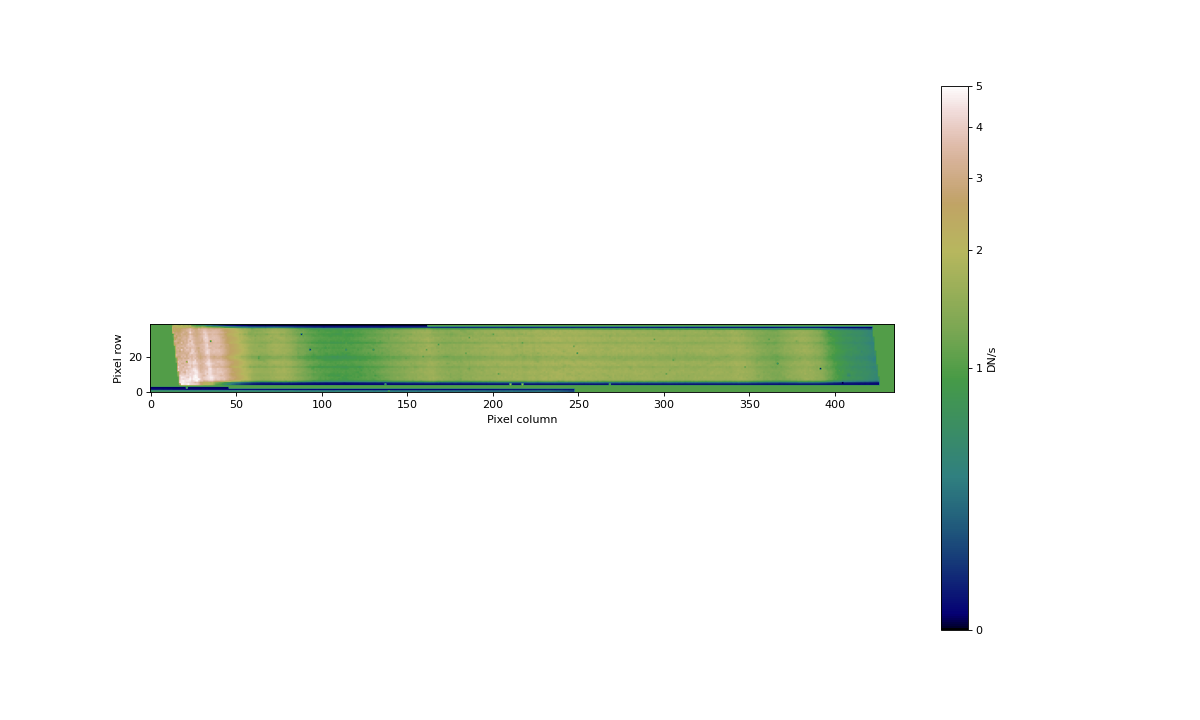

In [43]:
# plot the flat correction image - this is divided into the science exposure to apply the corrections per pixel
show_image(intflat.slits[0].data,0.,5.,aspect=1.,scale='Asinh',units='DN/s')

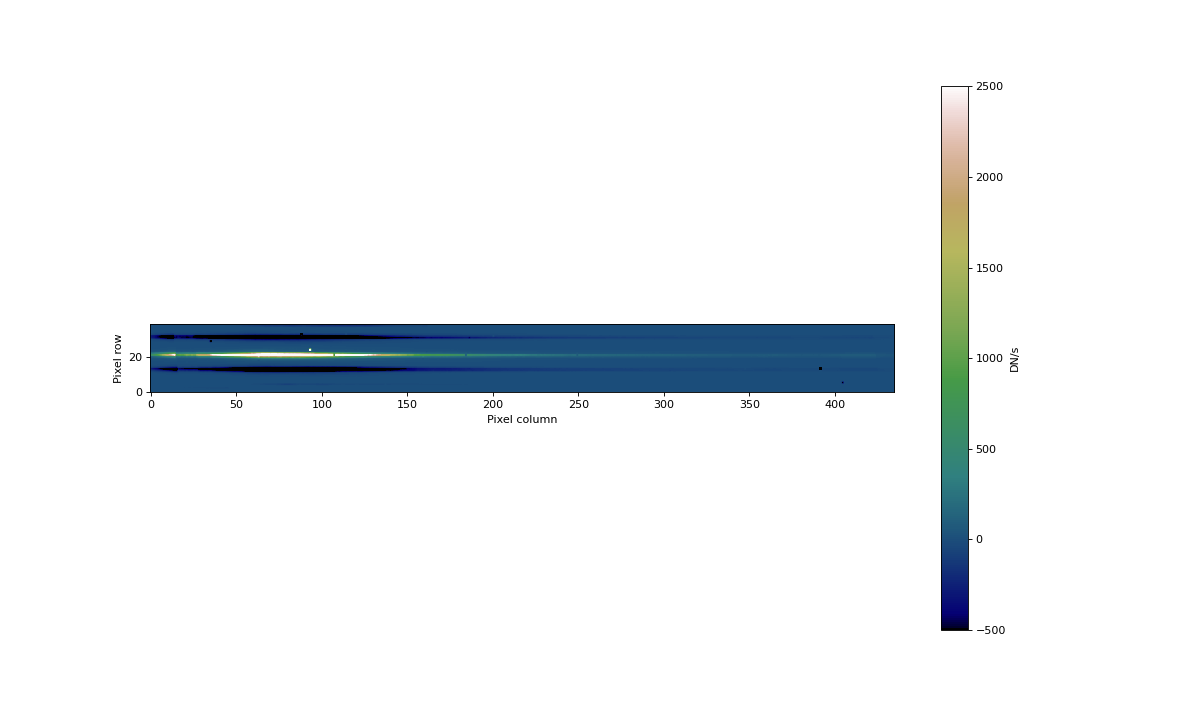

In [44]:
# plot the corrected science exposure
# note the simulation does not include all of the flat components, so applying the full correction in this case produces incorrect results
show_image(flat.slits[0].data,-5.e2,25.e2,aspect=1.,scale='linear',units='DN/s')

### pathloss <a id='pathloss'></a>

The pathloss correction scales the 2D spectrum as a function of wavelength to account for geometric and diffraction losses of a non-centered point source incurred by the slit aperture.  This is only relative to a centered source, as the absolute pathloss in that case has already been corrected by the F flat component of the flat field correction.

In [45]:
filename = root+'flatfieldstep.fits'  # the output from the previous step

step = PathLossStep()
step.save_results = True
step.output_dir = output_dir
result = step(filename)

2021-06-03 10:40:33,852 - stpipe.PathLossStep - INFO - PathLossStep instance created.
2021-06-03 10:40:33,990 - stpipe.PathLossStep - INFO - Step PathLossStep running with args ('./nirspec_files/nirspec_fssim_d5_flatfieldstep.fits',).
2021-06-03 10:40:33,992 - stpipe.PathLossStep - INFO - Step PathLossStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './nirspec_files/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2021-06-03 10:40:34,567 - stpipe.PathLossStep - INFO - Using PATHLOSS reference file /grp/crds/cache/references/jwst/jwst_nirspec_pathloss_0001.fits
2021-06-03 10:40:34,887 - stpipe.PathLossStep - INFO - Input exposure type is NRS_FIXEDSLIT
2021-06-03 10:40:35,114 - stpipe.PathLossStep - INFO - Working on slit S200A1
2021-06-03 10:40:35,115 - stpipe.PathLossStep - INFO 

In [46]:
# The output file has the suffix _pathlossstep appended:
ploss_output_file = root+'pathlossstep.fits'

# load the output into a data model container
ploss = datamodels.open(ploss_output_file)

2021-06-03 10:40:38,350 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



2021-06-03 10:40:40,398 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



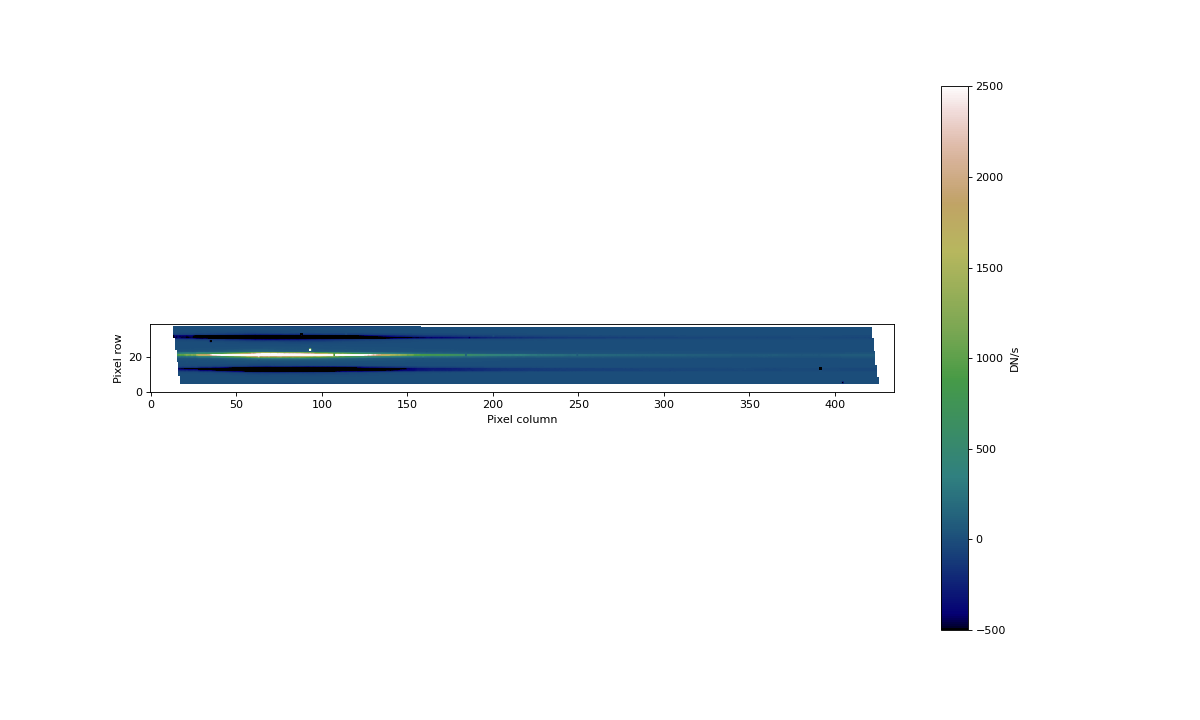

In [47]:
# plot the corrected science exposure
show_image(ploss.slits[0].data,-5.e2,25.e2,aspect=1.,scale='linear',units='DN/s')

### photom <a id='photom'></a>

The photom step applies a scalar conversion factor to convert to physical units.  Once on-orbit observations of spectrophotometric standards are obtained, this may also include a wavelength-dependent vector, if necessary, to account for any small discrepancies found in the throughput corrections.

In [48]:
filename = root+'pathlossstep.fits'  # the output from the previous step

step = PhotomStep()
step.save_results = True
step.output_dir = output_dir
result = step(filename)

2021-06-03 10:40:44,247 - stpipe.PhotomStep - INFO - PhotomStep instance created.
2021-06-03 10:40:44,381 - stpipe.PhotomStep - INFO - Step PhotomStep running with args ('./nirspec_files/nirspec_fssim_d5_pathlossstep.fits',).
2021-06-03 10:40:44,383 - stpipe.PhotomStep - INFO - Step PhotomStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './nirspec_files/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2021-06-03 10:40:44,857 - stpipe.PhotomStep - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_nirspec_photom_0014.fits
2021-06-03 10:40:44,857 - stpipe.PhotomStep - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_nirspec_area_0020.fits
2021-06-03 10:40:45,089 - stpipe.PhotomStep - INFO - Using instrument: NIRSPEC
2021-06-03 10:40:45,09

In [49]:
# The output file has the suffix _photomstep appended:
phot_output_file = root+'photomstep.fits'

# load the output into a data model container
phot = datamodels.open(phot_output_file)

2021-06-03 10:40:50,286 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



In [50]:
# what are the flux calibration-related keywords?
phot.find_fits_keyword('PHOTUJA2')
print('PHOTMJSR=',phot.slits[0].meta.photometry.conversion_megajanskys)
# note that despite the keyword name, when SRCTYPE=POINT, the units are actually MJy per pixel
# the pre-launch reference file has a placeholder value, so the output fluxes will appear unphysically large
print('PHOTUJA2=',phot.slits[0].meta.photometry.conversion_microjanskys)
# this is only applicable for extended sources

2021-06-03 10:40:51,096 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



PHOTMJSR= 1.0
PHOTUJA2= 23.50443053909789


### resample_spec <a id='resample'></a>

The fully calibrated 2D spectrum is resampled onto a rectified grid in sky and wavelength coordinates. This is intended for quick-look purposes only, as all of the calibrated unrectified exposures will be resampled and combined onto a common grid during the level 3 processing.

In [51]:
filename = root+'photomstep.fits'  # the output from the previous step

step = ResampleSpecStep()
step.save_results = True
step.output_dir = output_dir
result = step(filename)

2021-06-03 10:40:55,700 - stpipe.ResampleSpecStep - INFO - ResampleSpecStep instance created.
2021-06-03 10:40:55,846 - stpipe.ResampleSpecStep - INFO - Step ResampleSpecStep running with args ('./nirspec_files/nirspec_fssim_d5_photomstep.fits',).
2021-06-03 10:40:55,849 - stpipe.ResampleSpecStep - INFO - Step ResampleSpecStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './nirspec_files/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2021-06-03 10:40:56,168 - stpipe.ResampleSpecStep - INFO - No NIRSpec DIRZPARS reffile
2021-06-03 10:40:56,169 - stpipe.ResampleSpecStep - INFO -   setting: pixfrac=1.0
2021-06-03 10:40:56,170 - stpipe.ResampleSpecStep - IN

In [52]:
# The output file has the suffix _resamplespecstep appended:
s2d_output_file = root+'resamplespecstep.fits'

# load the output into a data model container
s2d = datamodels.open(s2d_output_file)

2021-06-03 10:40:58,353 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



2021-06-03 10:41:01,008 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



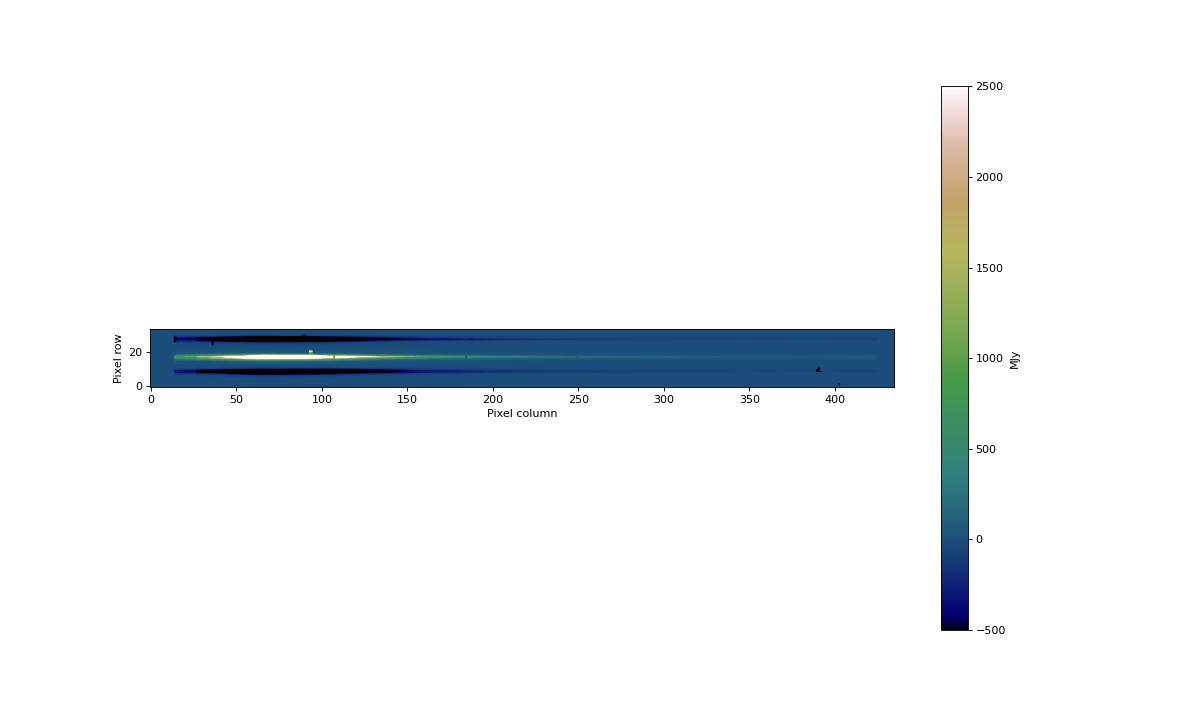

In [53]:
# plot the rectified 2D spectrum
show_image(s2d.slits[0].data,-5.e2,25.e2,aspect=1.,scale='linear',units='MJy')

### extract_1d <a id='extract1d'></a>

A 1D spectrum is extracted from the resampled 2D product, using an aperture size specified from a reference file.  An aperture correction is also applied to account for flux outside of the extraction aperture. As with the resample_spec level 2b product, this is intended for quick-look purposes only.  An independent extraction of the combined rectified 2D spectrum will be done during level 3 processing.

In [54]:
filename = root+'resamplespecstep.fits'  # the output from the previous step

step = Extract1dStep()
step.save_results = True
step.output_dir = output_dir
result = step(filename)

2021-06-03 10:41:11,587 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2021-06-03 10:41:11,741 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('./nirspec_files/nirspec_fssim_d5_resamplespecstep.fits',).
2021-06-03 10:41:11,743 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './nirspec_files/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}
2021-06-03 10:41:11,948 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_nirspec_extract1d_0004.json
2021-06-03 10:41:12,032 - stpipe.Extract1dStep - INFO - Using APCO

In [55]:
# The output file has the suffix _extract1dstep appended:
x1d_output_file = root+'extract1dstep.fits'

# load the output into a data model container
x1d = datamodels.open(x1d_output_file)

2021-06-03 10:41:16,623 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



2021-06-03 10:41:17,972 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



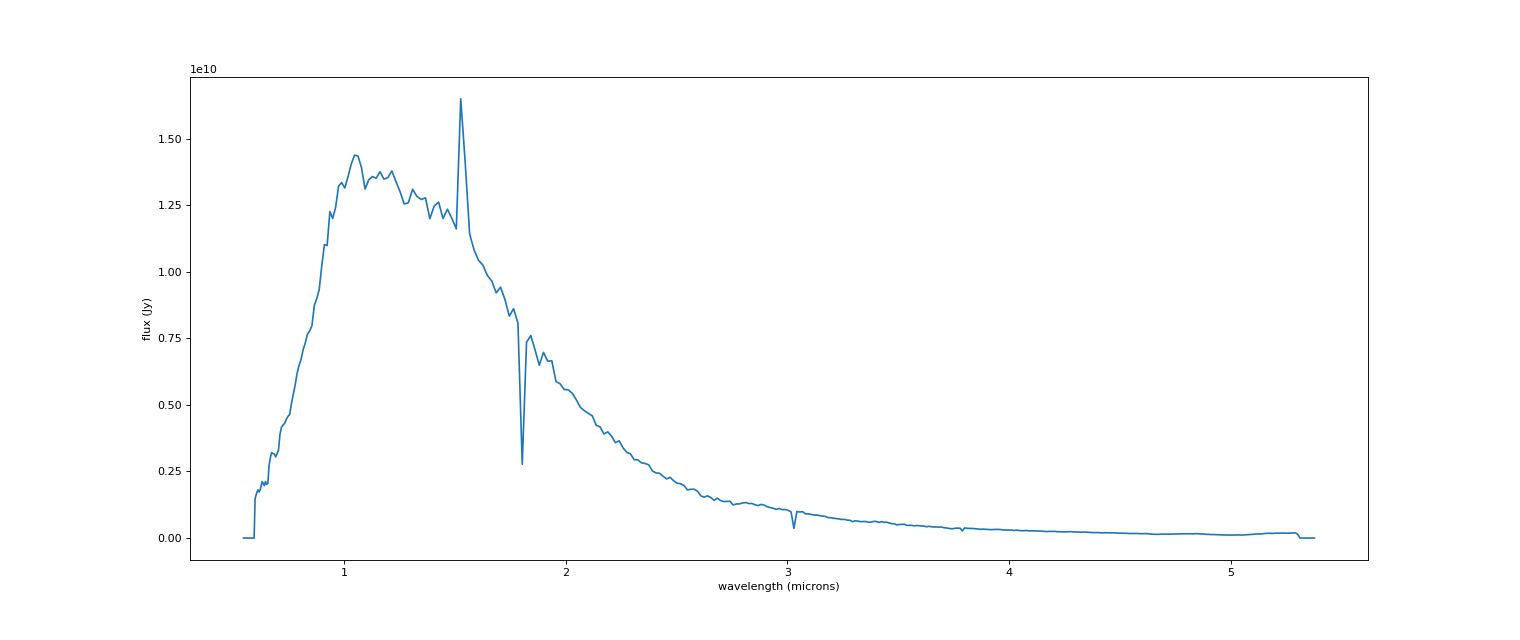

In [56]:
# plot the spectrum
x1dwave = x1d.spec[0].spec_table.WAVELENGTH
x1dflux = x1d.spec[0].spec_table.FLUX

fig = plt.figure(figsize=(19,8))
plt.plot(x1dwave,x1dflux)
plt.xlabel('wavelength (microns)')
plt.ylabel('flux (Jy)')
plt.show()

# note that the flux level appears artificially inflated because of the dummy flux conversion factor applied in the photom step

In [ ]:
# try a second pass with a new reference file containing a different extraction aperture size...

## Run the calwebb_spec3 pipeline <a id='runspec3'></a>

For an observation that contains multiple exposures of the same source, such as the nod set in this example, this pipeline will combine all of the exposures into a single output product.  Both a rectified 2D and extracted 1D spectrum are generated.  This process also includes an outlier detection step that compares the stack of values at each resampled pixel and flags outliers based on noise threshold parameters; the flagged outliers are not included in the spectral combination.

In [57]:
# run the calwebb_spec3 pipeline using association file of cal.fits files

# get the association file
asn = output_dir+"spec3_all_asn.json"

# loop over the association files (one per exposure)
spec3 = Spec3Pipeline()
spec3.save_results = True
spec3.output_dir = output_dir
spec3.outlier_detection.skip = True  # skip this step for now, because the simulations do not include noise
result = spec3(asn)

2021-06-03 10:41:50,350 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

2021-06-03 10:41:50,359 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2021-06-03 10:41:50,361 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2021-06-03 10:41:50,363 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2021-06-03 10:41:50,365 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2021-06-03 10:41:50,368 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2021-06-03 10:41:50,370 - stpipe.Spec3Pipeline.resample_

2021-06-03 10:41:57,727 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2021-06-03 10:41:57,731 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2021-06-03 10:41:57,915 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2021-06-03 10:41:57,918 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': './nirspec_files', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2021-06-03 10:41:58,064 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2021-06-03 10:41:58,065 - stpipe.Spec3P

2021-06-03 10:41:59,686 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (40, 435) --> (54, 436)
2021-06-03 10:41:59,702 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  90.753006050 -70.775659587 90.756339613 -70.775659587 90.756339613 -70.774561975 90.753006050 -70.774561975
2021-06-03 10:42:00,150 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in ./nirspec_files/nirspec_fssim_s00001_nirspec_clear-prism-s200a1-subs200a1_s2d.fits
2021-06-03 10:42:00,150 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2021-06-03 10:42:00,349 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(54, 436) from nirspec_fssim_s00001_nirspec_clear-prism-s200a1-subs200a1_s2d.fits>,).
2021-06-03 10:42:00,351 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False,

2021-06-03 10:42:18,567 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Text(0.5, 0, 'wavelength (microns)')

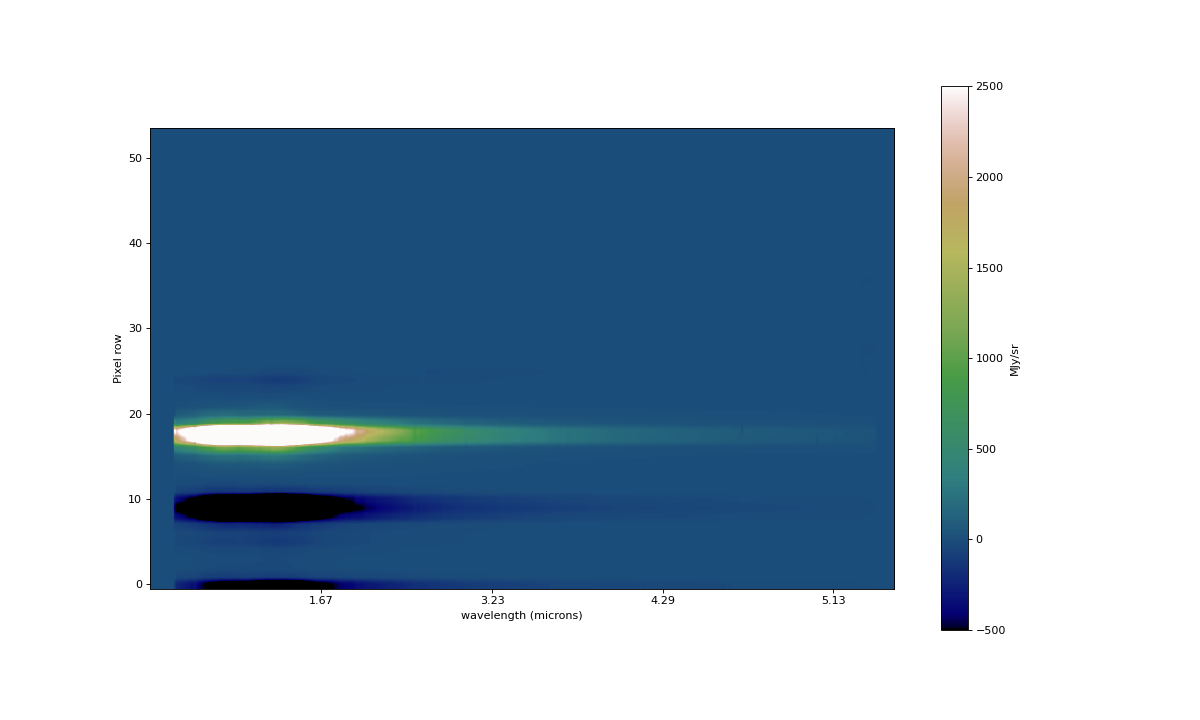

In [58]:
# display level 3 products
# combined 2D rectified spectrum
s2d3 = datamodels.open(output_dir+'nirspec_fssim_s00001_nirspec_clear-prism-s200a1-subs200a1_s2d.fits')
s2d3sci = s2d3.data

# get the wavelength scale
wcsobj = s2d3.meta.wcs
y, x = np.mgrid[:s2d3sci.shape[0], : s2d3sci.shape[1]]
det2sky = wcsobj.get_transform('detector','world')
s2d3ra, s2d3dec, s2d3wave = det2sky(x,y)
s2d3waves = s2d3wave[0,:]
xtint = np.arange(100,s2d3sci.shape[1],100)
xtlab = np.round(s2d3waves[xtint],2)

# show the combined s2d image
show_image(s2d3sci,-5.e2,2.5e3,aspect=5.,scale='linear')
plt.xticks(xtint,xtlab)
plt.xlabel('wavelength (microns)')

2021-06-03 10:43:49,941 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



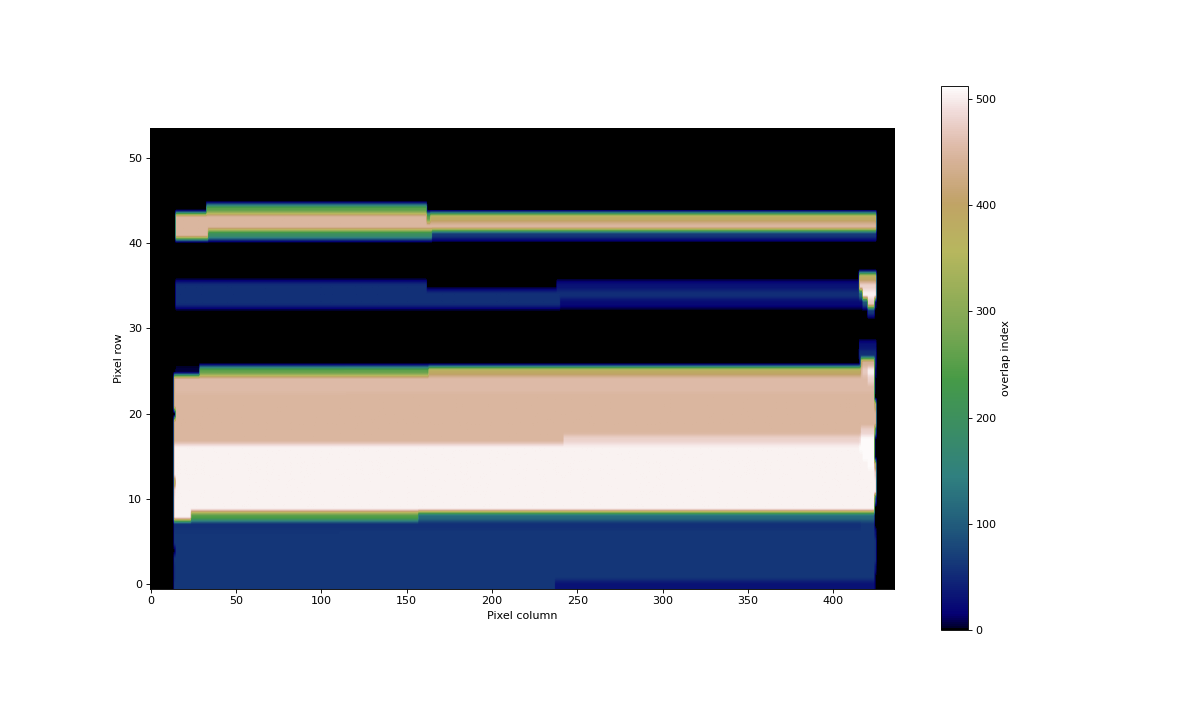

In [59]:
# show the overlap image ("CON" fits extension)
s2d3con = s2d3.con
show_image(s2d3con,0,512,aspect=5.,scale='linear',units='overlap index')

2021-06-03 10:44:19,571 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



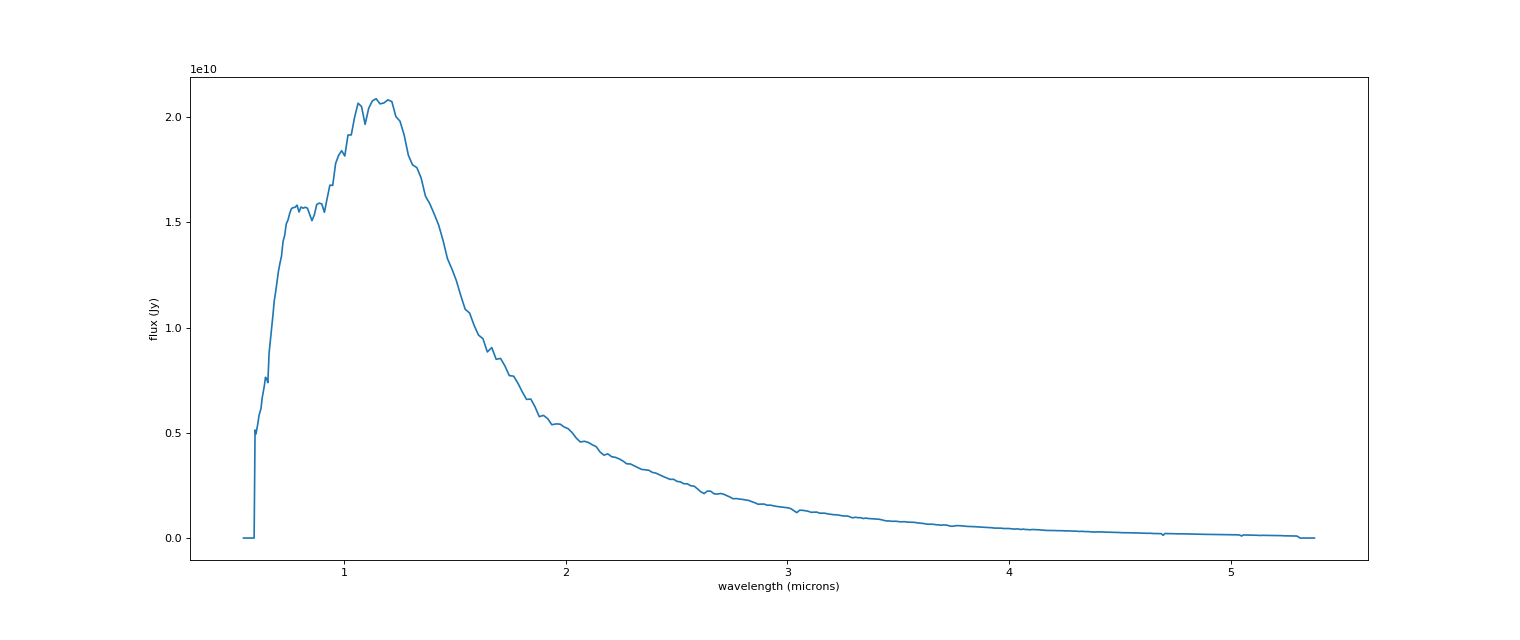

In [61]:
# combined 1D extracted spectrum
x1d3 = datamodels.open(output_dir+'nirspec_fssim_s00001_nirspec_clear-prism-s200a1-subs200a1_x1d.fits')

# get wavelength & flux
x1d3wave = x1d3.spec[0].spec_table.WAVELENGTH
x1d3flux = x1d3.spec[0].spec_table.FLUX

# plot
fig = plt.figure(figsize=(19,8))
plt.plot(x1d3wave,x1d3flux)
plt.xlabel('wavelength (microns)')
plt.ylabel('flux (Jy)')
plt.show()